## Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import silhouette_score
pd.set_option('display.max_columns',100)
import warnings
warnings.filterwarnings('ignore')

## Reading the data

In [2]:
# Path to SQLite database
database_path = 'candidate_data.db'

# Create a connection to the SQLite database
conn = sqlite3.connect(database_path)

# SQL query to select all data from the training data table
query_train = "SELECT * FROM train_data"

# Load data from the SQL query into a pandas DataFrame
df_train = pd.read_sql_query(query_train, conn)

# SQL query to select all data from the testing data table
query_test = "SELECT * FROM test_data"

# Load data from the SQL query into a pandas DataFrame
df_test = pd.read_sql_query(query_test, conn)

# Close the connection to the database
conn.close()

## Cleaning Corrected Data

In [3]:
#Cleaning the data
df_train['name'] = df_train['name'].str.replace('\n','')
df_train['name'] = df_train['name'].str.strip()

## Null Value Imputation

In [4]:
df_train['job_role'].fillna('NA',inplace=True)
df_train['tags'].fillna('NA',inplace=True)
df_train['gold_badges'].fillna('NA',inplace=True)
df_train['silver_badges'].fillna('0',inplace=True)
df_train['bronze_badges'].fillna('0',inplace=True)
df_train['questions'].fillna('0',inplace=True)
df_train['answers'].fillna('0',inplace=True)
df_train['reputation'].fillna('0',inplace=True)
df_train['reached'].fillna('0',inplace=True)
df_train['posts_edited'].fillna('0',inplace=True)
df_train['votes_cast'].fillna('0',inplace=True)
df_train['helpful_tags'].fillna('0',inplace=True)

# DATA CLEANING

## 1. Remove , from all numerical columns

In [5]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

## 2. Clean k and m values

In [6]:
df_train['reached'] = df_train['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_train['reached'] = df_train['reached'].apply(convert_k_to_num)

## 3. Cleaning Member_Since

In [7]:
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_train['member_since_in_months'] = df_train['member_since'].apply(convert_to_months)
df_train['member_since_in_months'] = df_train['member_since_in_months'].round(2)

## Type Casting

In [8]:
df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_train[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

## FEATURE ENGINEERING

## C++ DEVELOPER SKILLS

### programming languages - C++

## Creating flags for all the skills

In [9]:
df_train['weighted_badge_score'] = (3 * df_train['gold_badges']) + (2 * df_train['silver_badges']) + df_train['bronze_badges']
df_train['questions'] = np.where(df_train['questions']==0, 1, df_train['questions'])
df_train['QA_ratio'] = (df_train['answers']/df_train['questions']).round(2)

#dropping this because there's a weighted badge score
df_train.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

In [10]:
df_train['tags'] = df_train['tags'].apply(lambda x:x.split(','))
df_train['Programming_Language_Flag'] = np.where(df_train['tags'].apply(lambda x:'c++' in x),1,0)
df_train['total_requirements_satisfied'] = df_train['Programming_Language_Flag']

In [11]:
df_train.shape

(34279, 18)

## Shortlisting C++ Developers

In [12]:
df_train = df_train[(df_train['total_requirements_satisfied']==1)]

In [13]:
df_train[(df_train['total_requirements_satisfied']==1)].shape

(1890, 18)

## Transformations

REPUTATION 

       Transformation      Skew
               Actual 11.531236
                  Log -0.159659
           Reciprocal  2.569285
Exponential power 0.2  0.965782
Exponential power 0.3  1.693971
          Square Root  3.581885
            Cube Root  1.961808
               Boxcox -0.018780

 Best Transformation for  reputation : 
 Boxcox = -0.018779856694580262


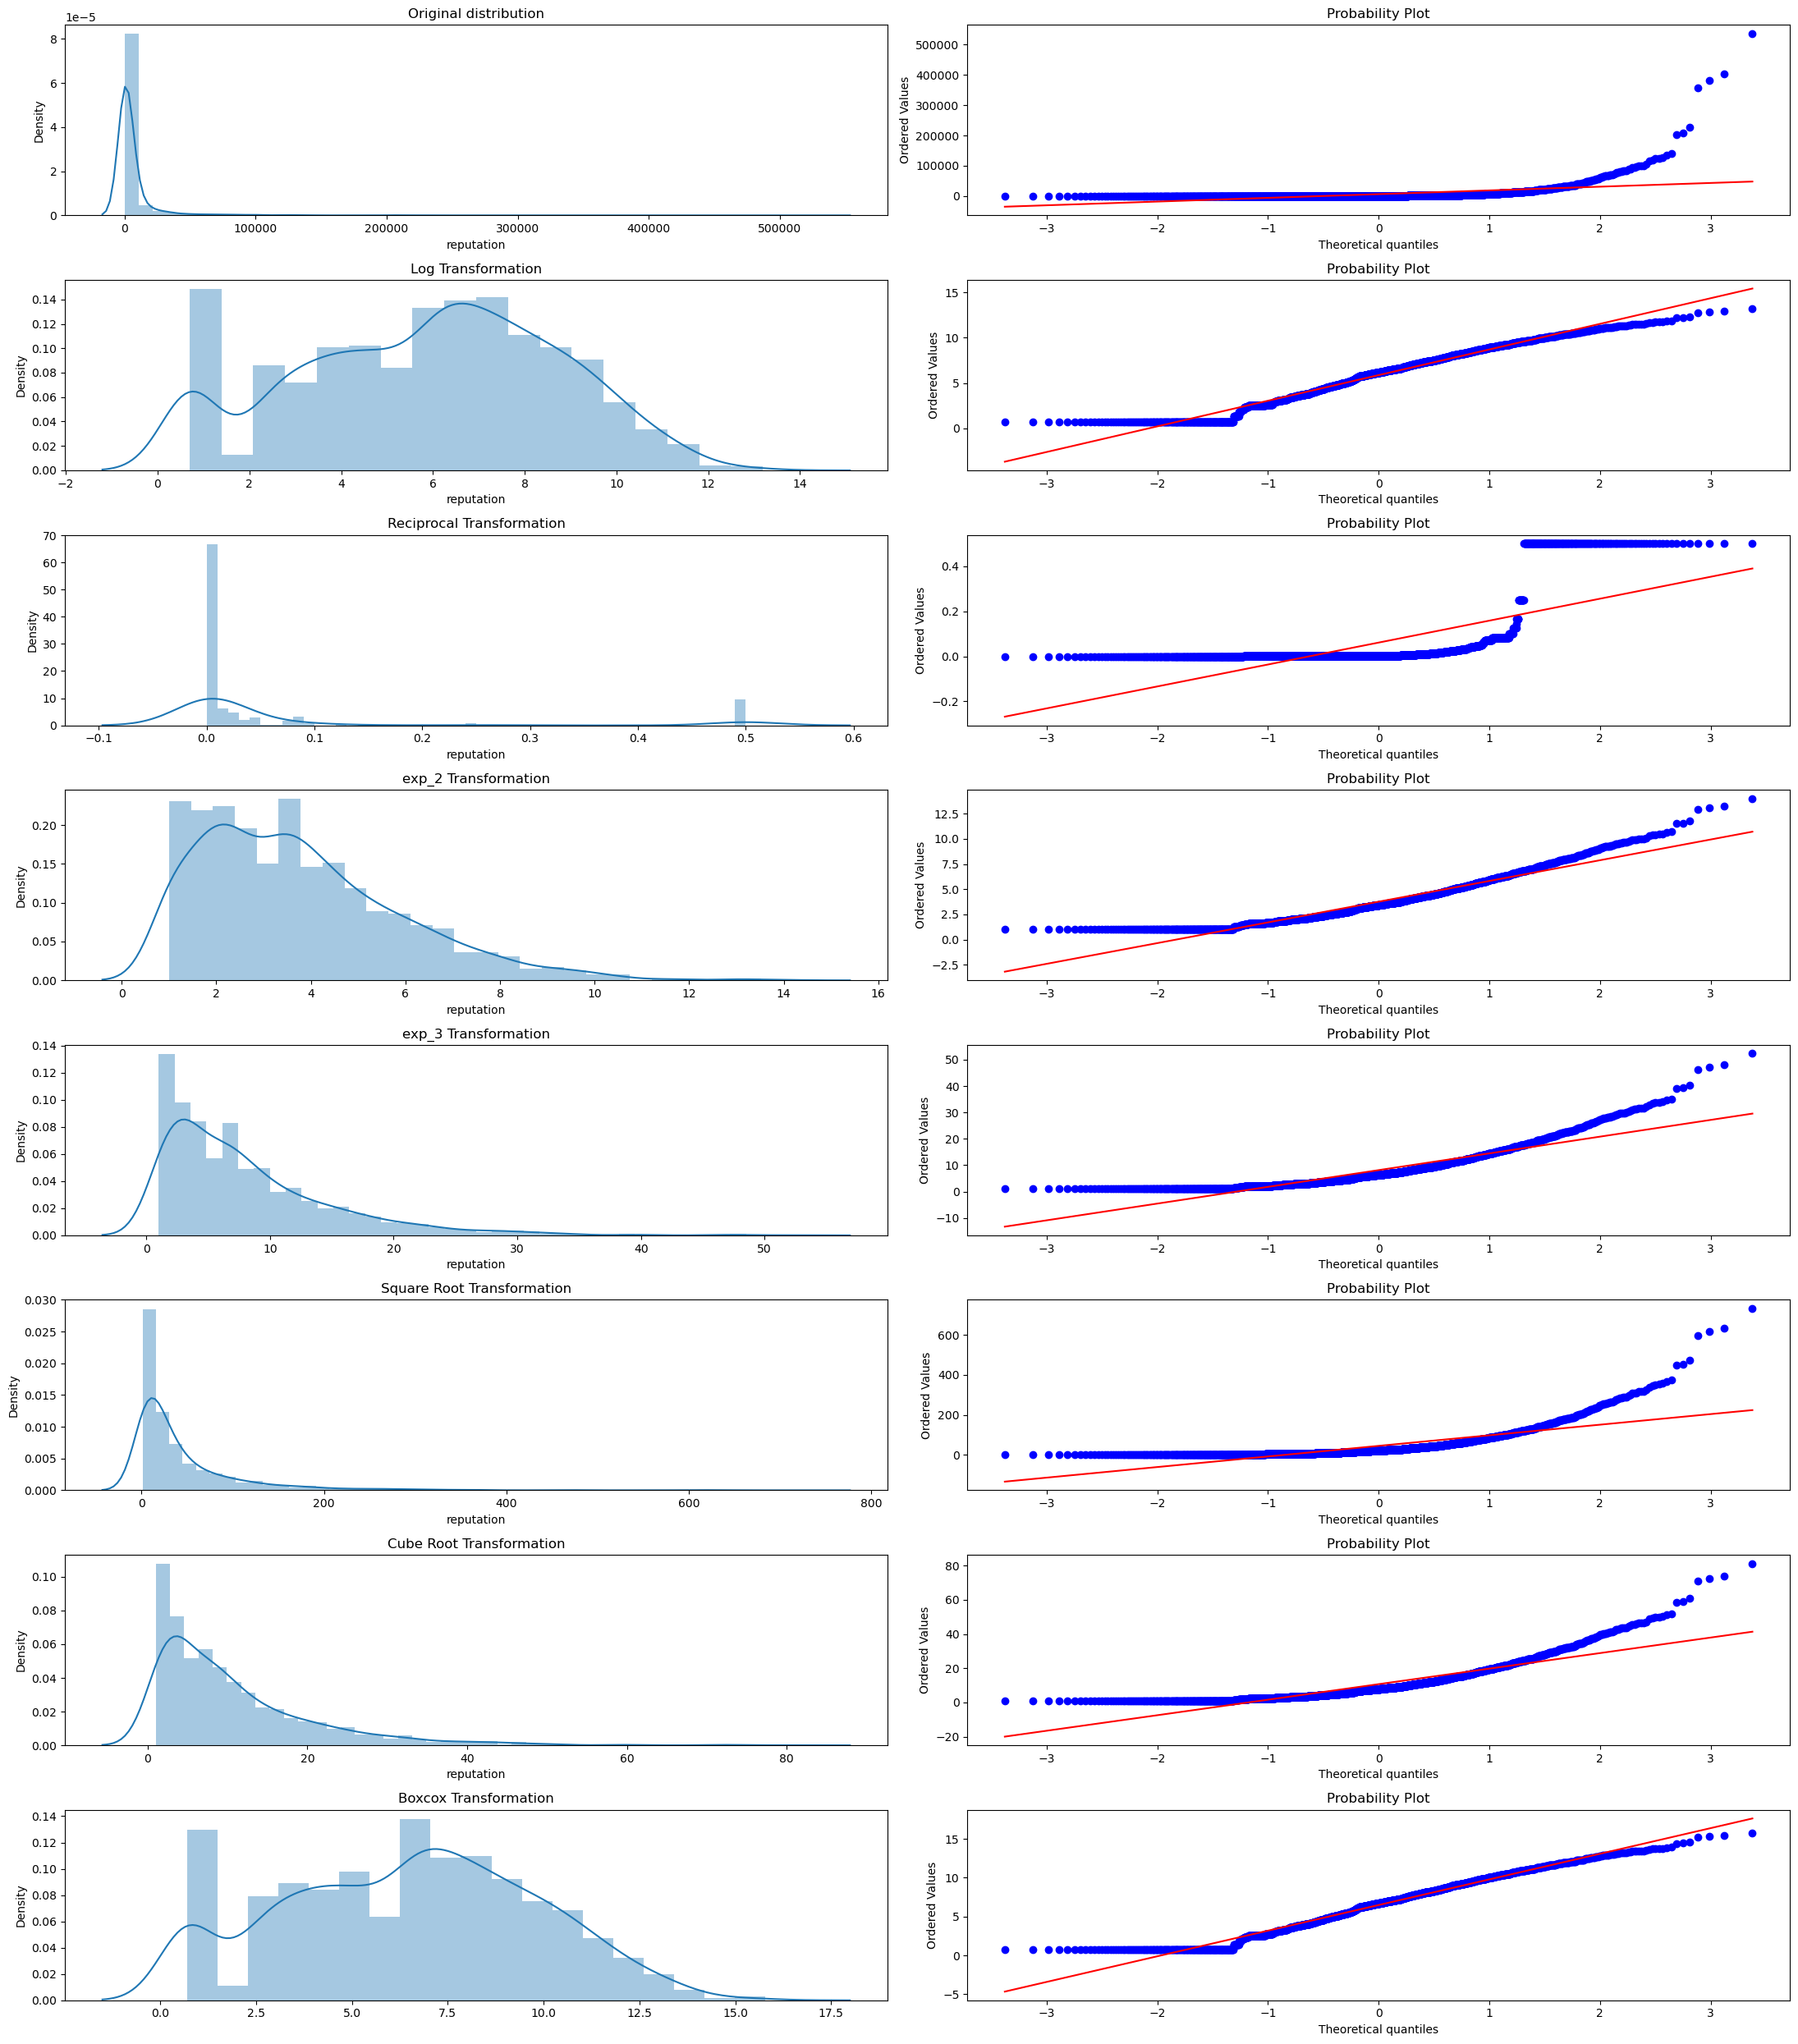

REACHED 

       Transformation      Skew
               Actual 10.287024
                  Log -0.254766
           Reciprocal 24.011184
Exponential power 0.2  0.963482
Exponential power 0.3  1.639436
          Square Root  3.224574
            Cube Root  1.877626
               Boxcox -0.038516

 Best Transformation for  reached : 
 Boxcox = -0.03851578182215076


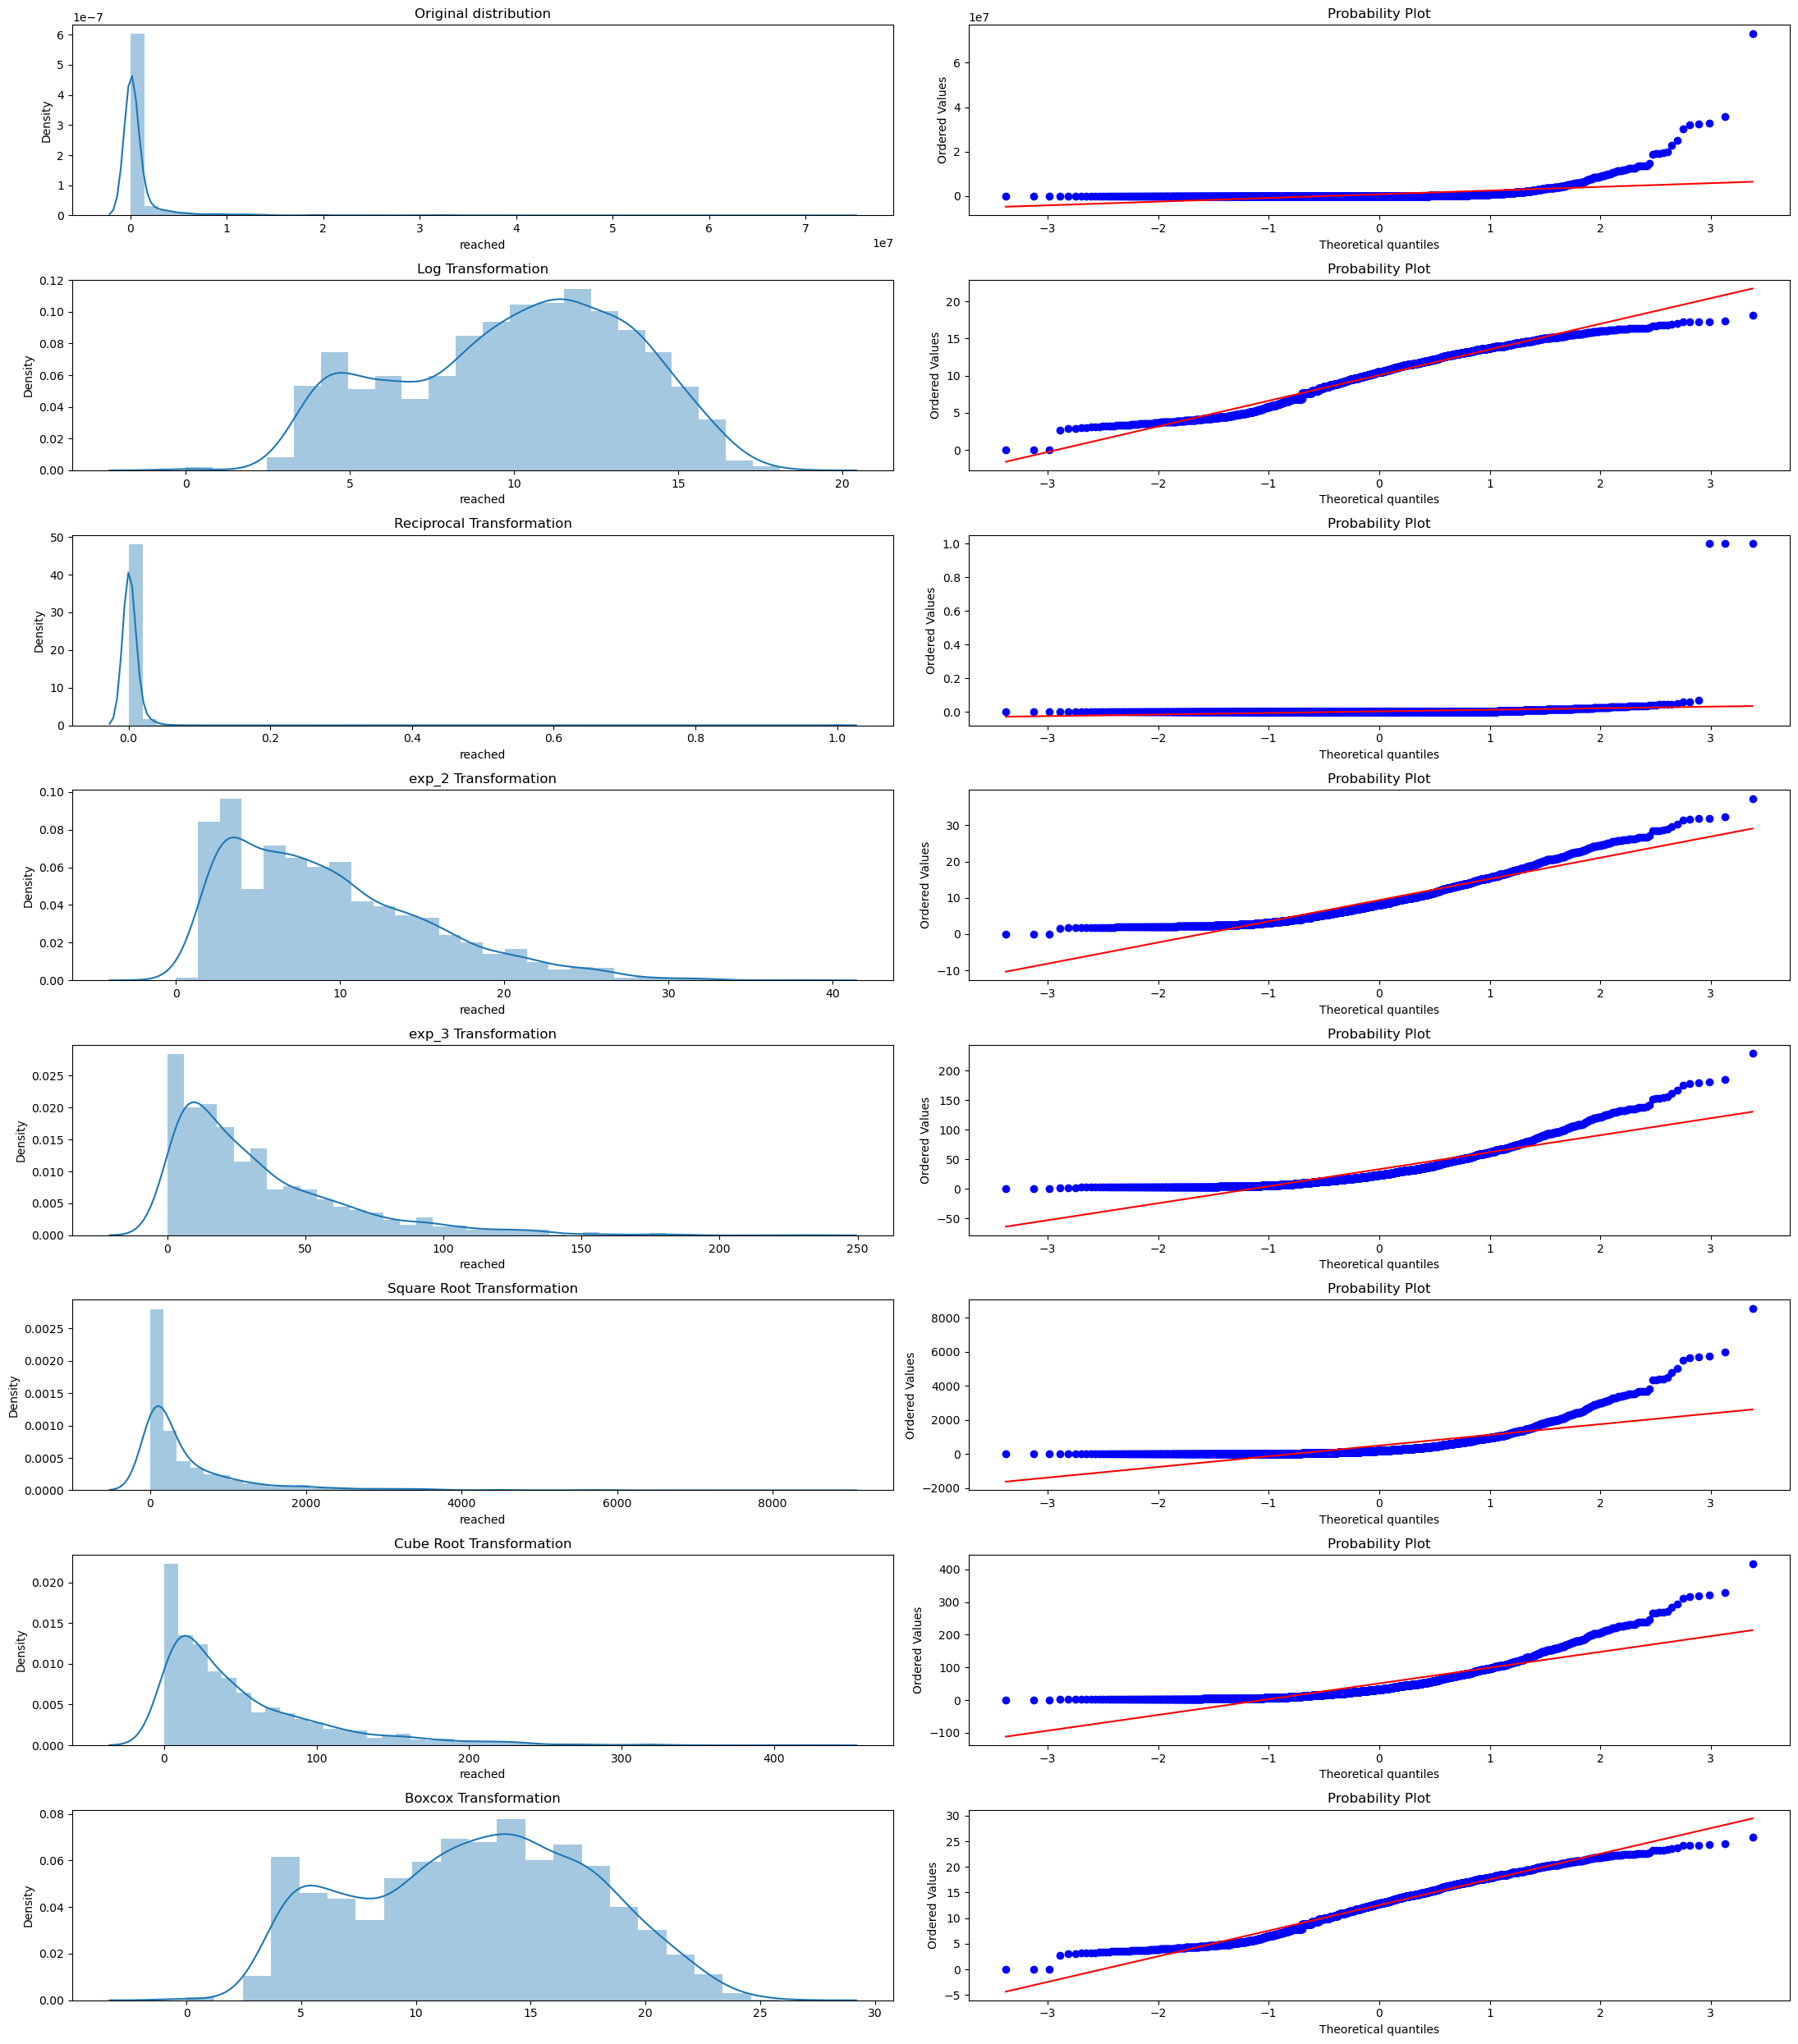

QUESTIONS 

       Transformation     Skew
               Actual 5.047827
                  Log 0.368869
           Reciprocal 1.269297
Exponential power 0.2 0.799906
Exponential power 0.3 1.172062
          Square Root 2.019582
            Cube Root 1.303249
               Boxcox 0.061593

 Best Transformation for  questions : 
 Boxcox = 0.06159285993292487


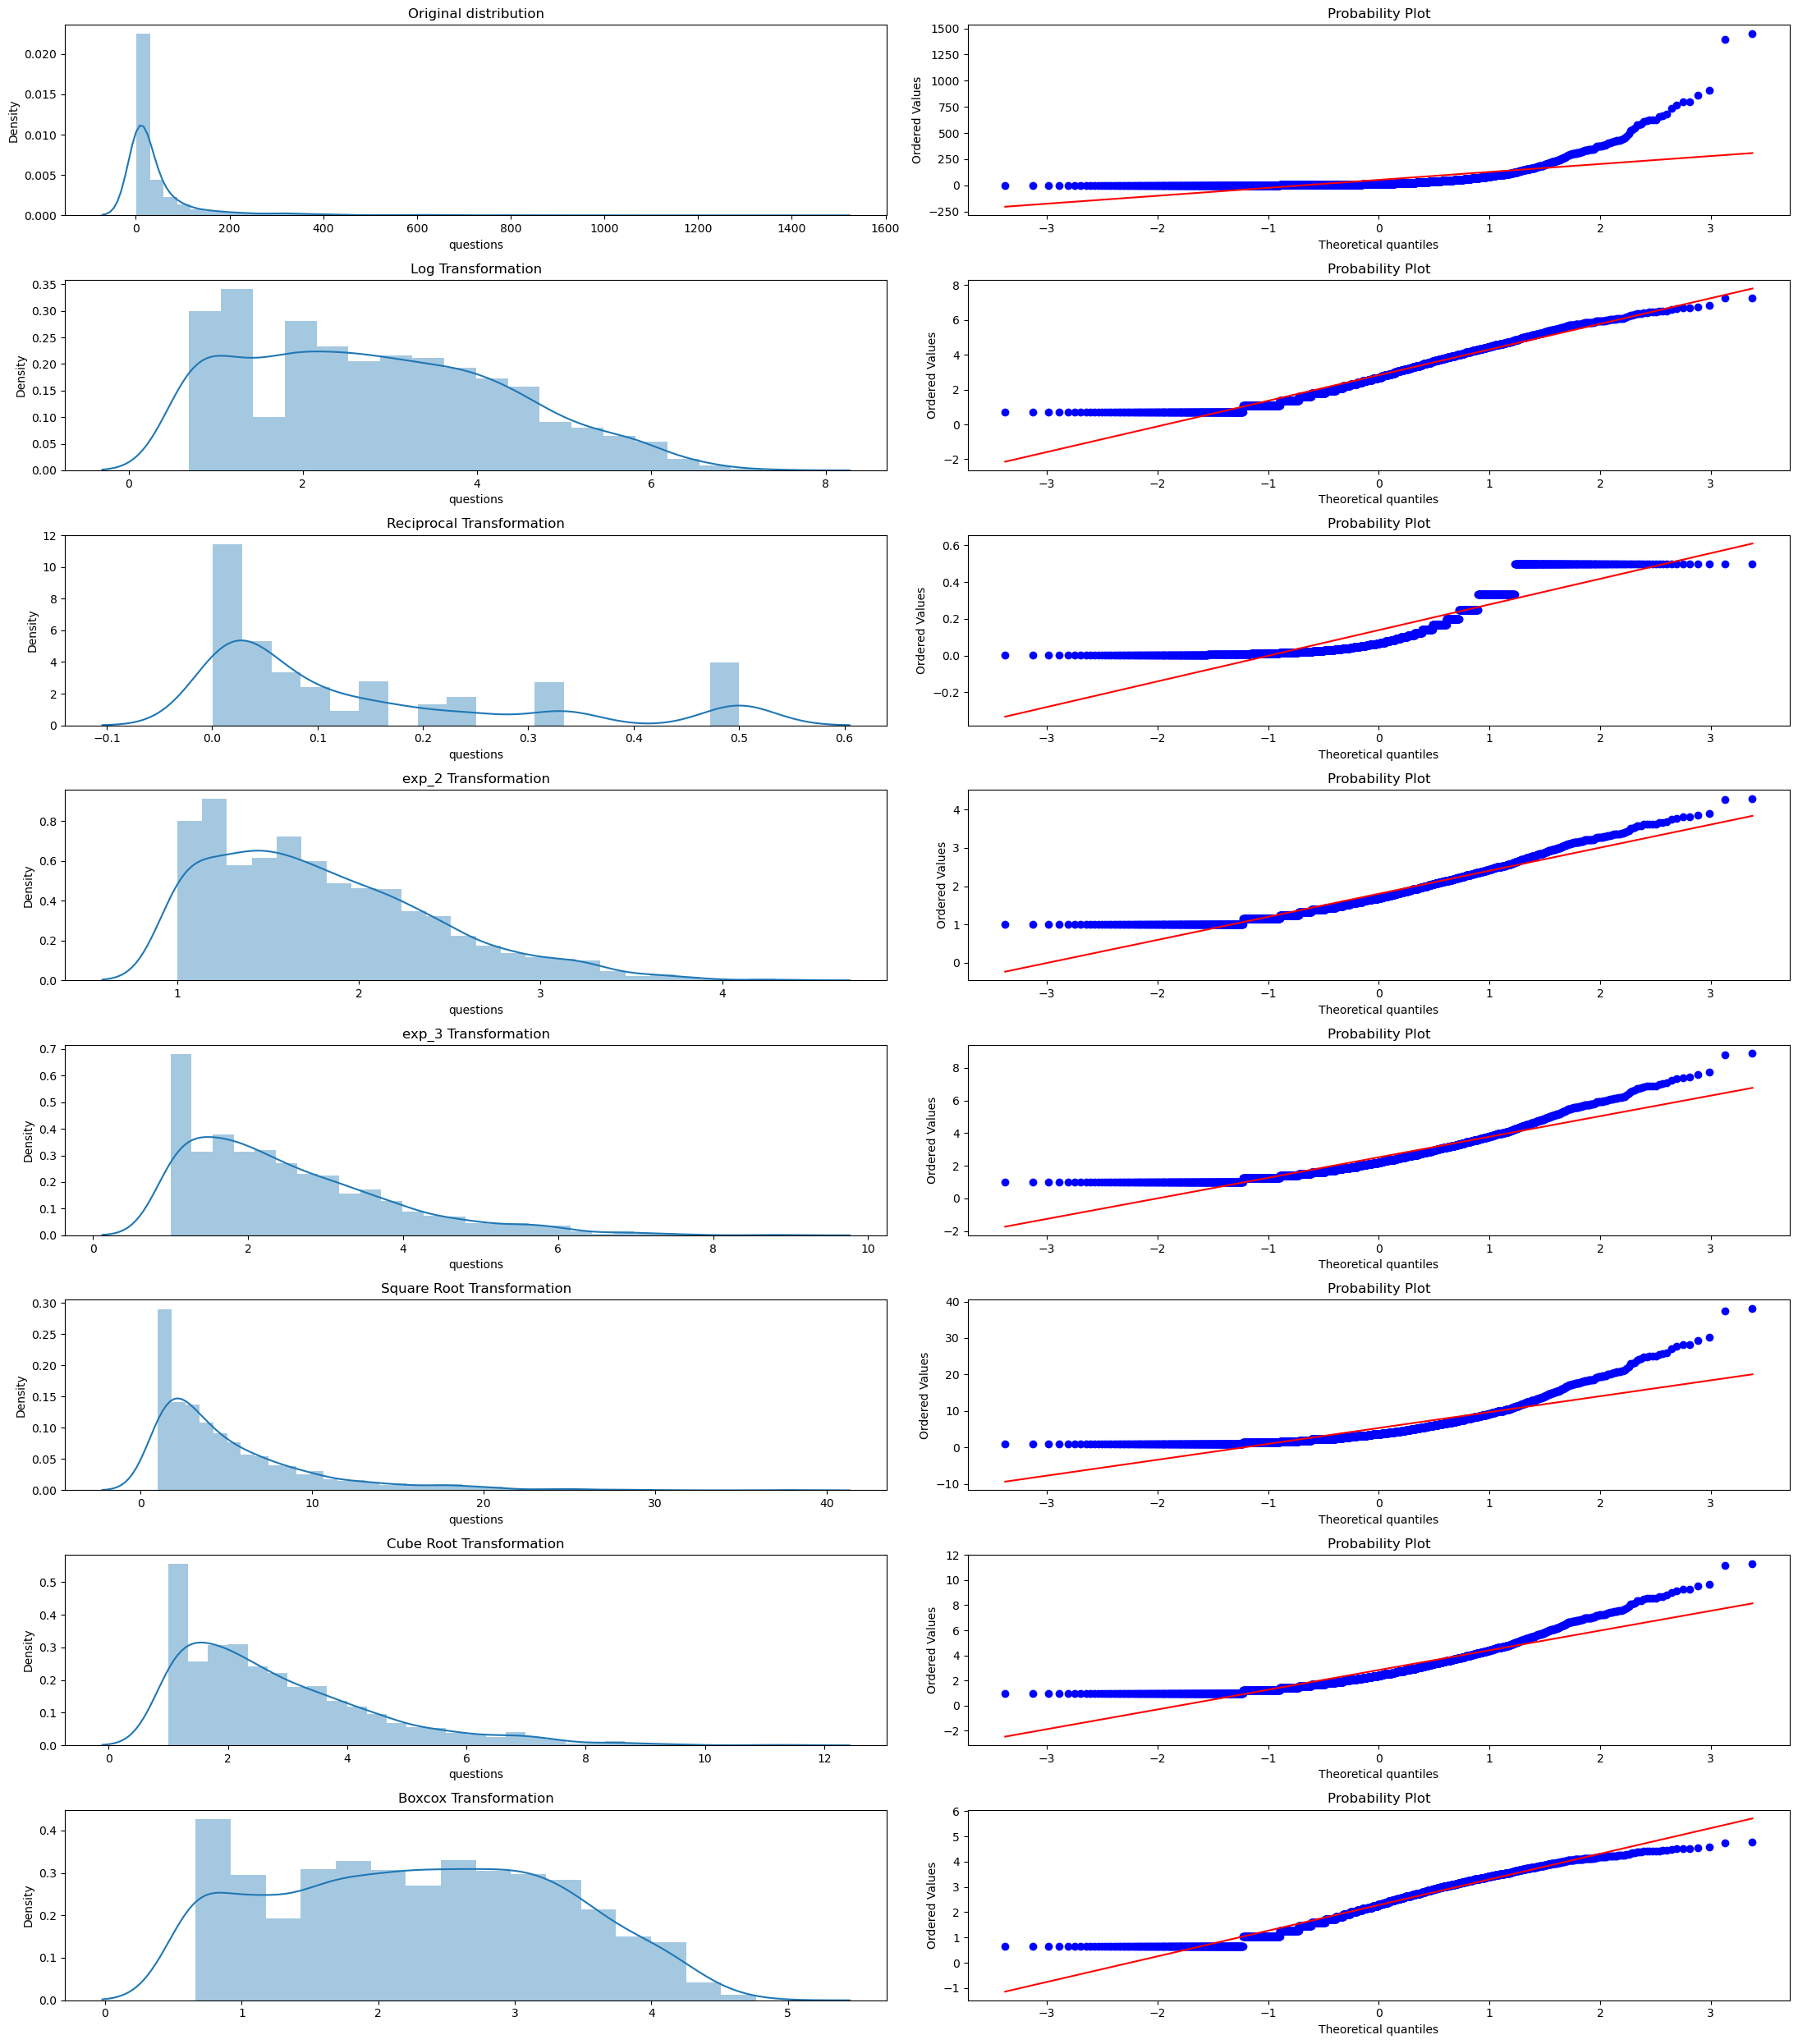

ANSWERS 

       Transformation      Skew
               Actual 15.786870
                  Log  0.792313
           Reciprocal  0.680941
Exponential power 0.2  0.566341
Exponential power 0.3  1.866127
          Square Root  4.769157
            Cube Root  2.312091
               Boxcox  0.168868

 Best Transformation for  answers : 
 Boxcox = 0.16886766319286775


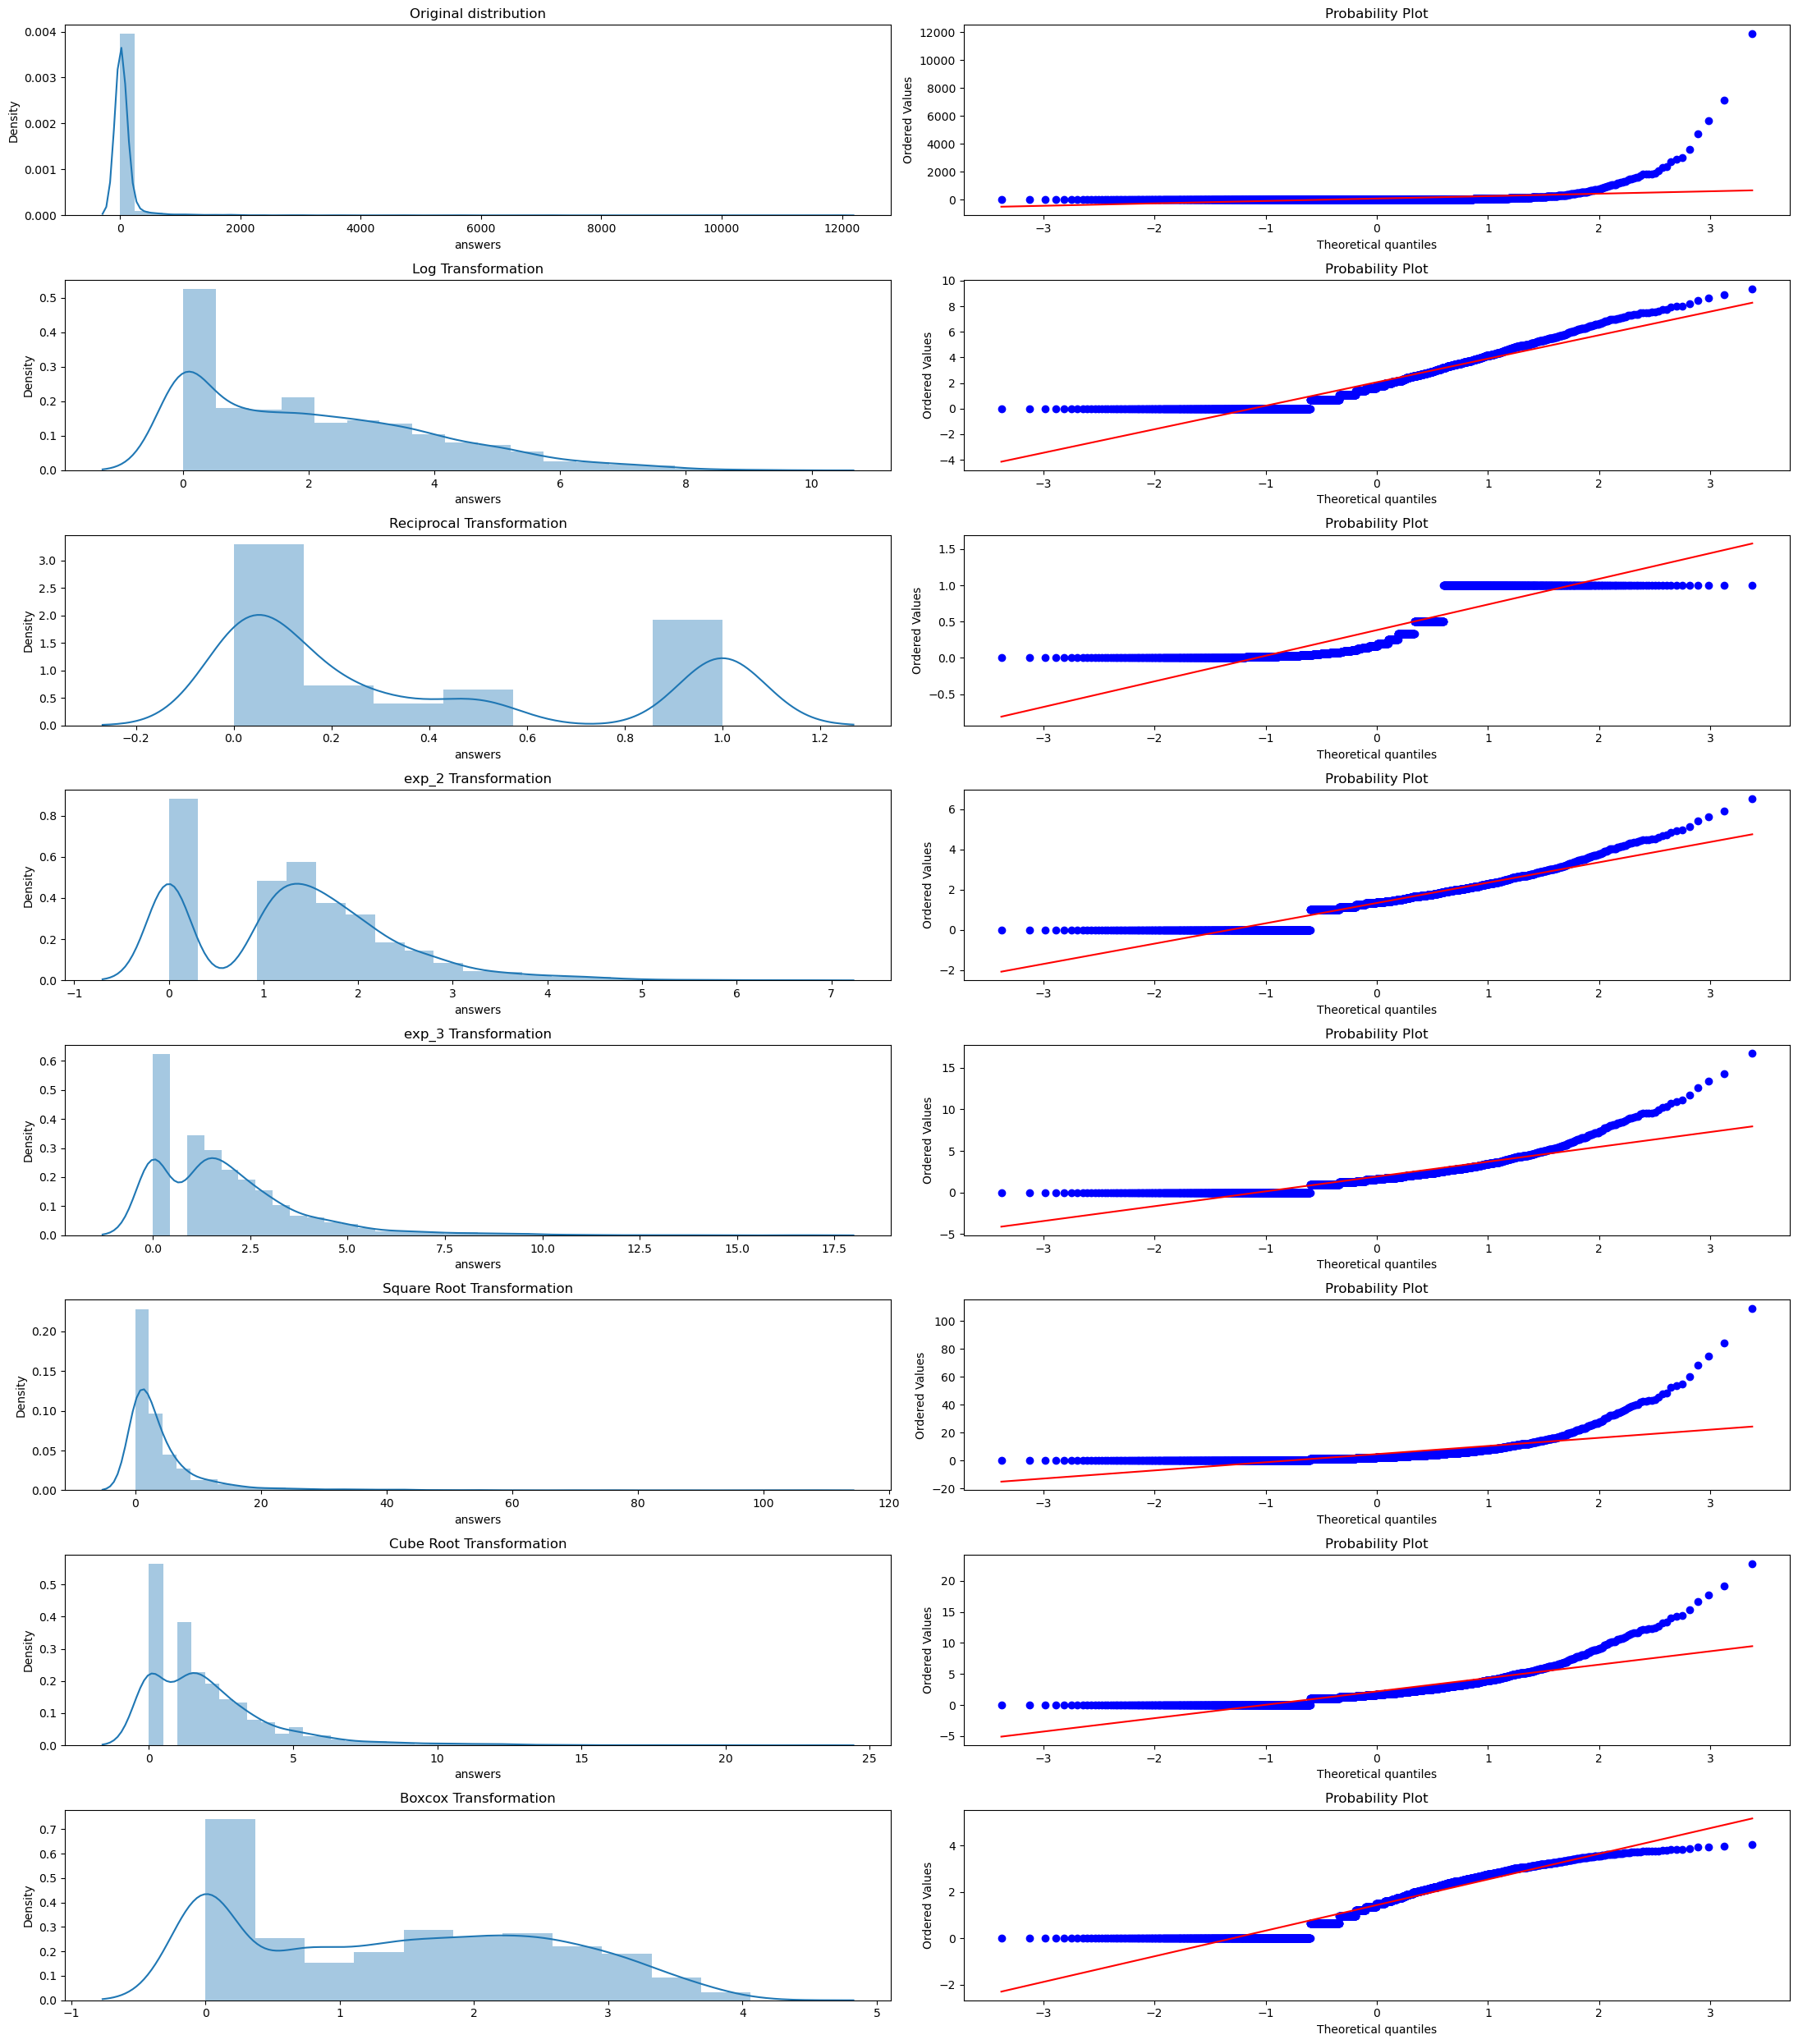

POSTS_EDITED 

       Transformation      Skew
               Actual 19.390142
                  Log  2.094969
           Reciprocal -0.926707
Exponential power 0.2  1.813814
Exponential power 0.3  3.480262
          Square Root  8.876895
            Cube Root  4.223913
               Boxcox  0.958332

 Best Transformation for  posts_edited : 
 Reciprocal = -0.9267066239790649


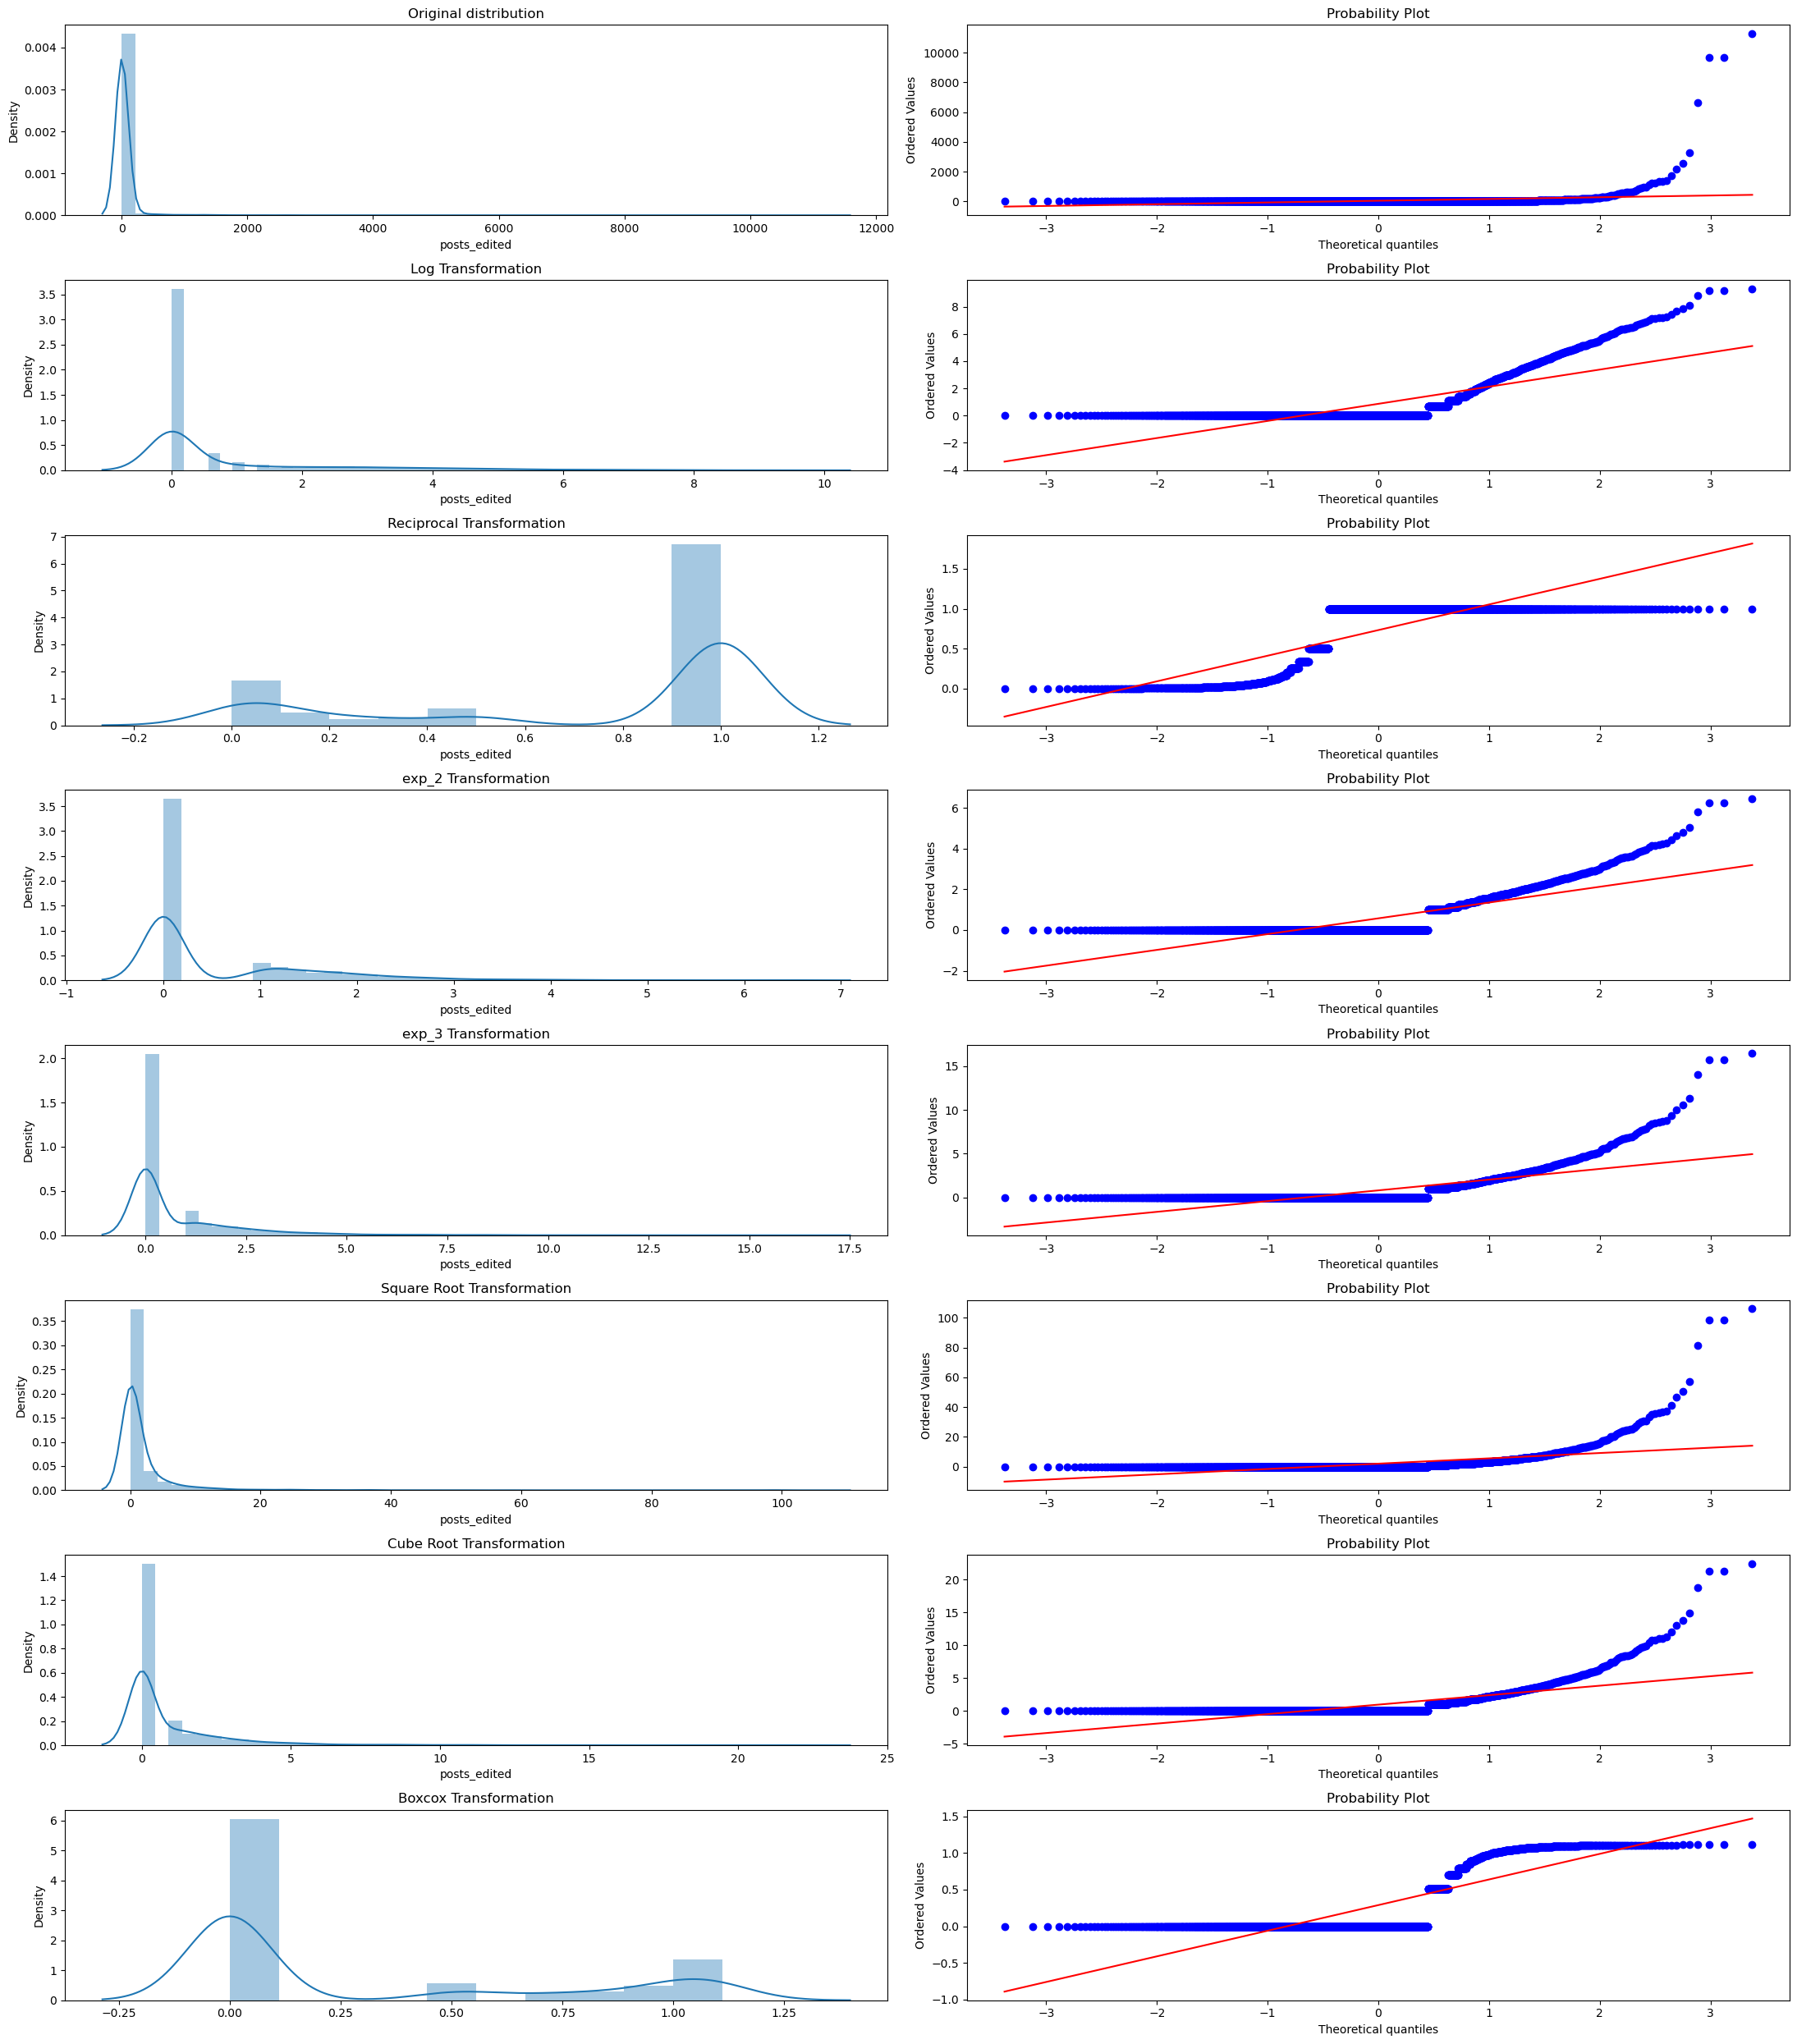

HELPFUL_TAGS 

       Transformation      Skew
               Actual 42.202996
                  Log  2.661115
           Reciprocal -1.132456
Exponential power 0.2  2.209141
Exponential power 0.3  5.145363
          Square Root 20.223289
            Cube Root  6.794872
               Boxcox  1.072426

 Best Transformation for  helpful_tags : 
 Boxcox = 1.0724259429186185


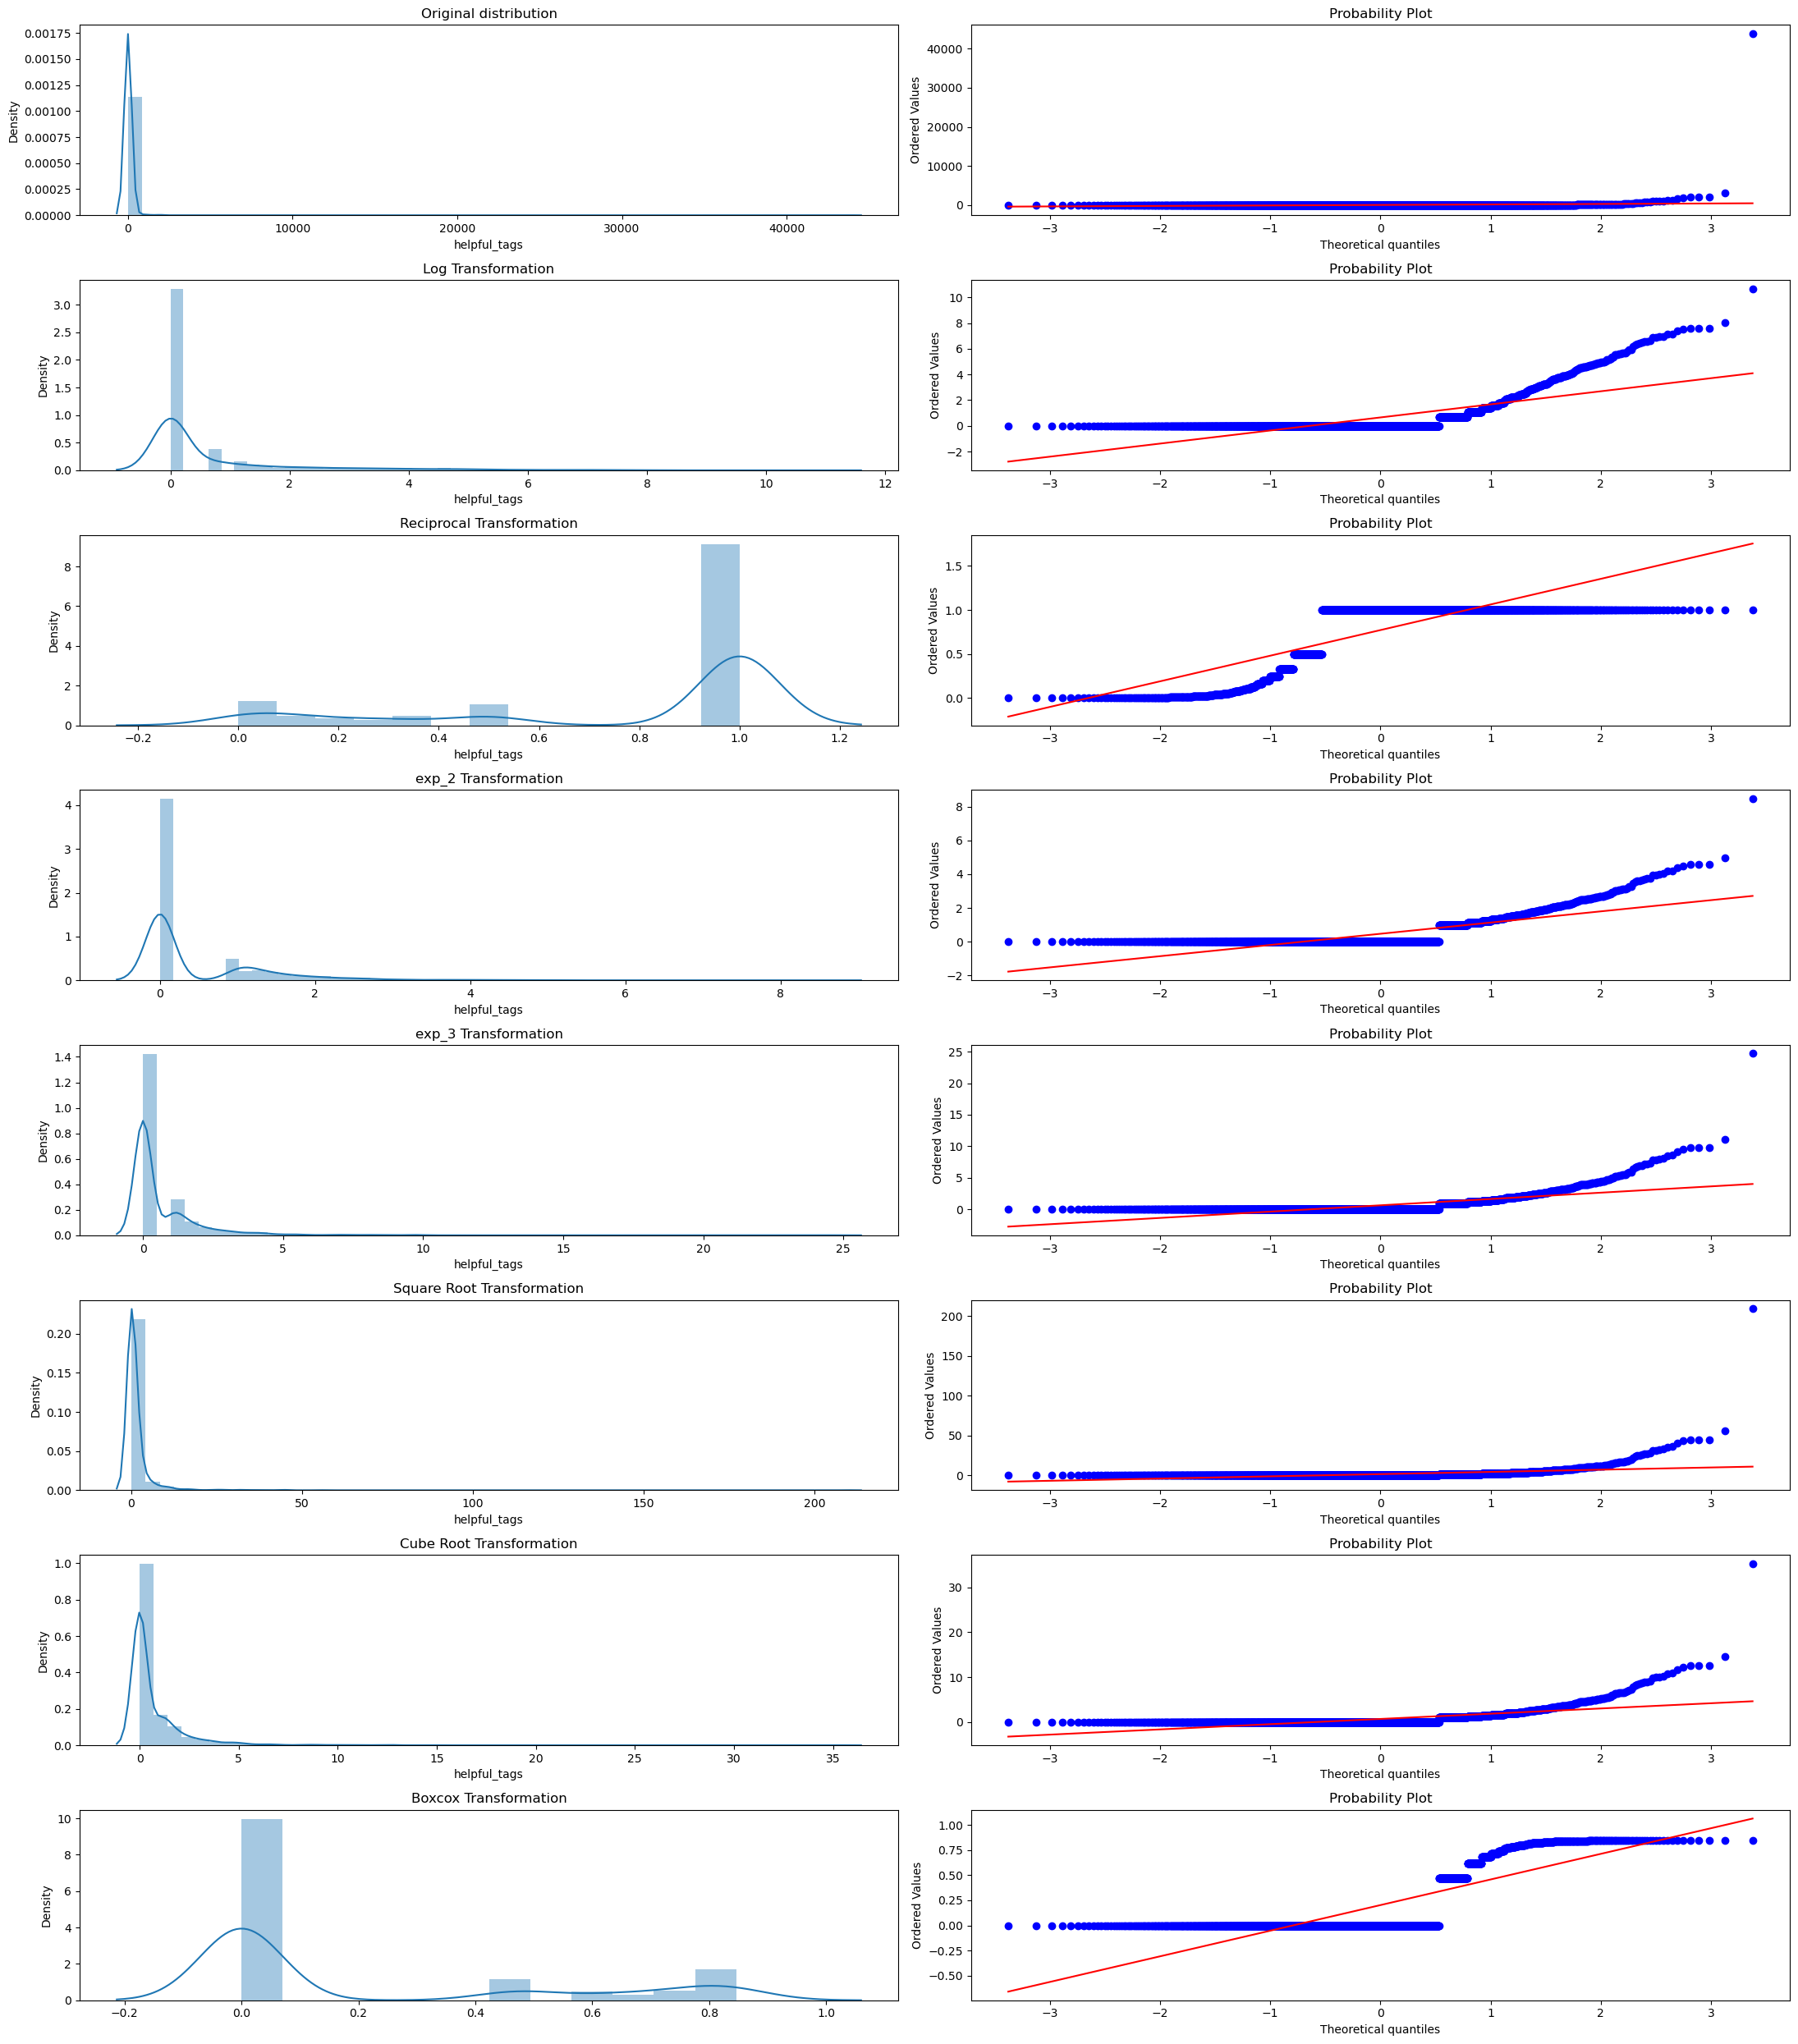

VOTES_CAST 

       Transformation     Skew
               Actual 9.393832
                  Log 0.165515
           Reciprocal 1.127720
Exponential power 0.2 0.431200
Exponential power 0.3 1.332342
          Square Root 3.086159
            Cube Root 1.612474
               Boxcox 0.040482

 Best Transformation for  votes_cast : 
 Boxcox = 0.04048182587422911


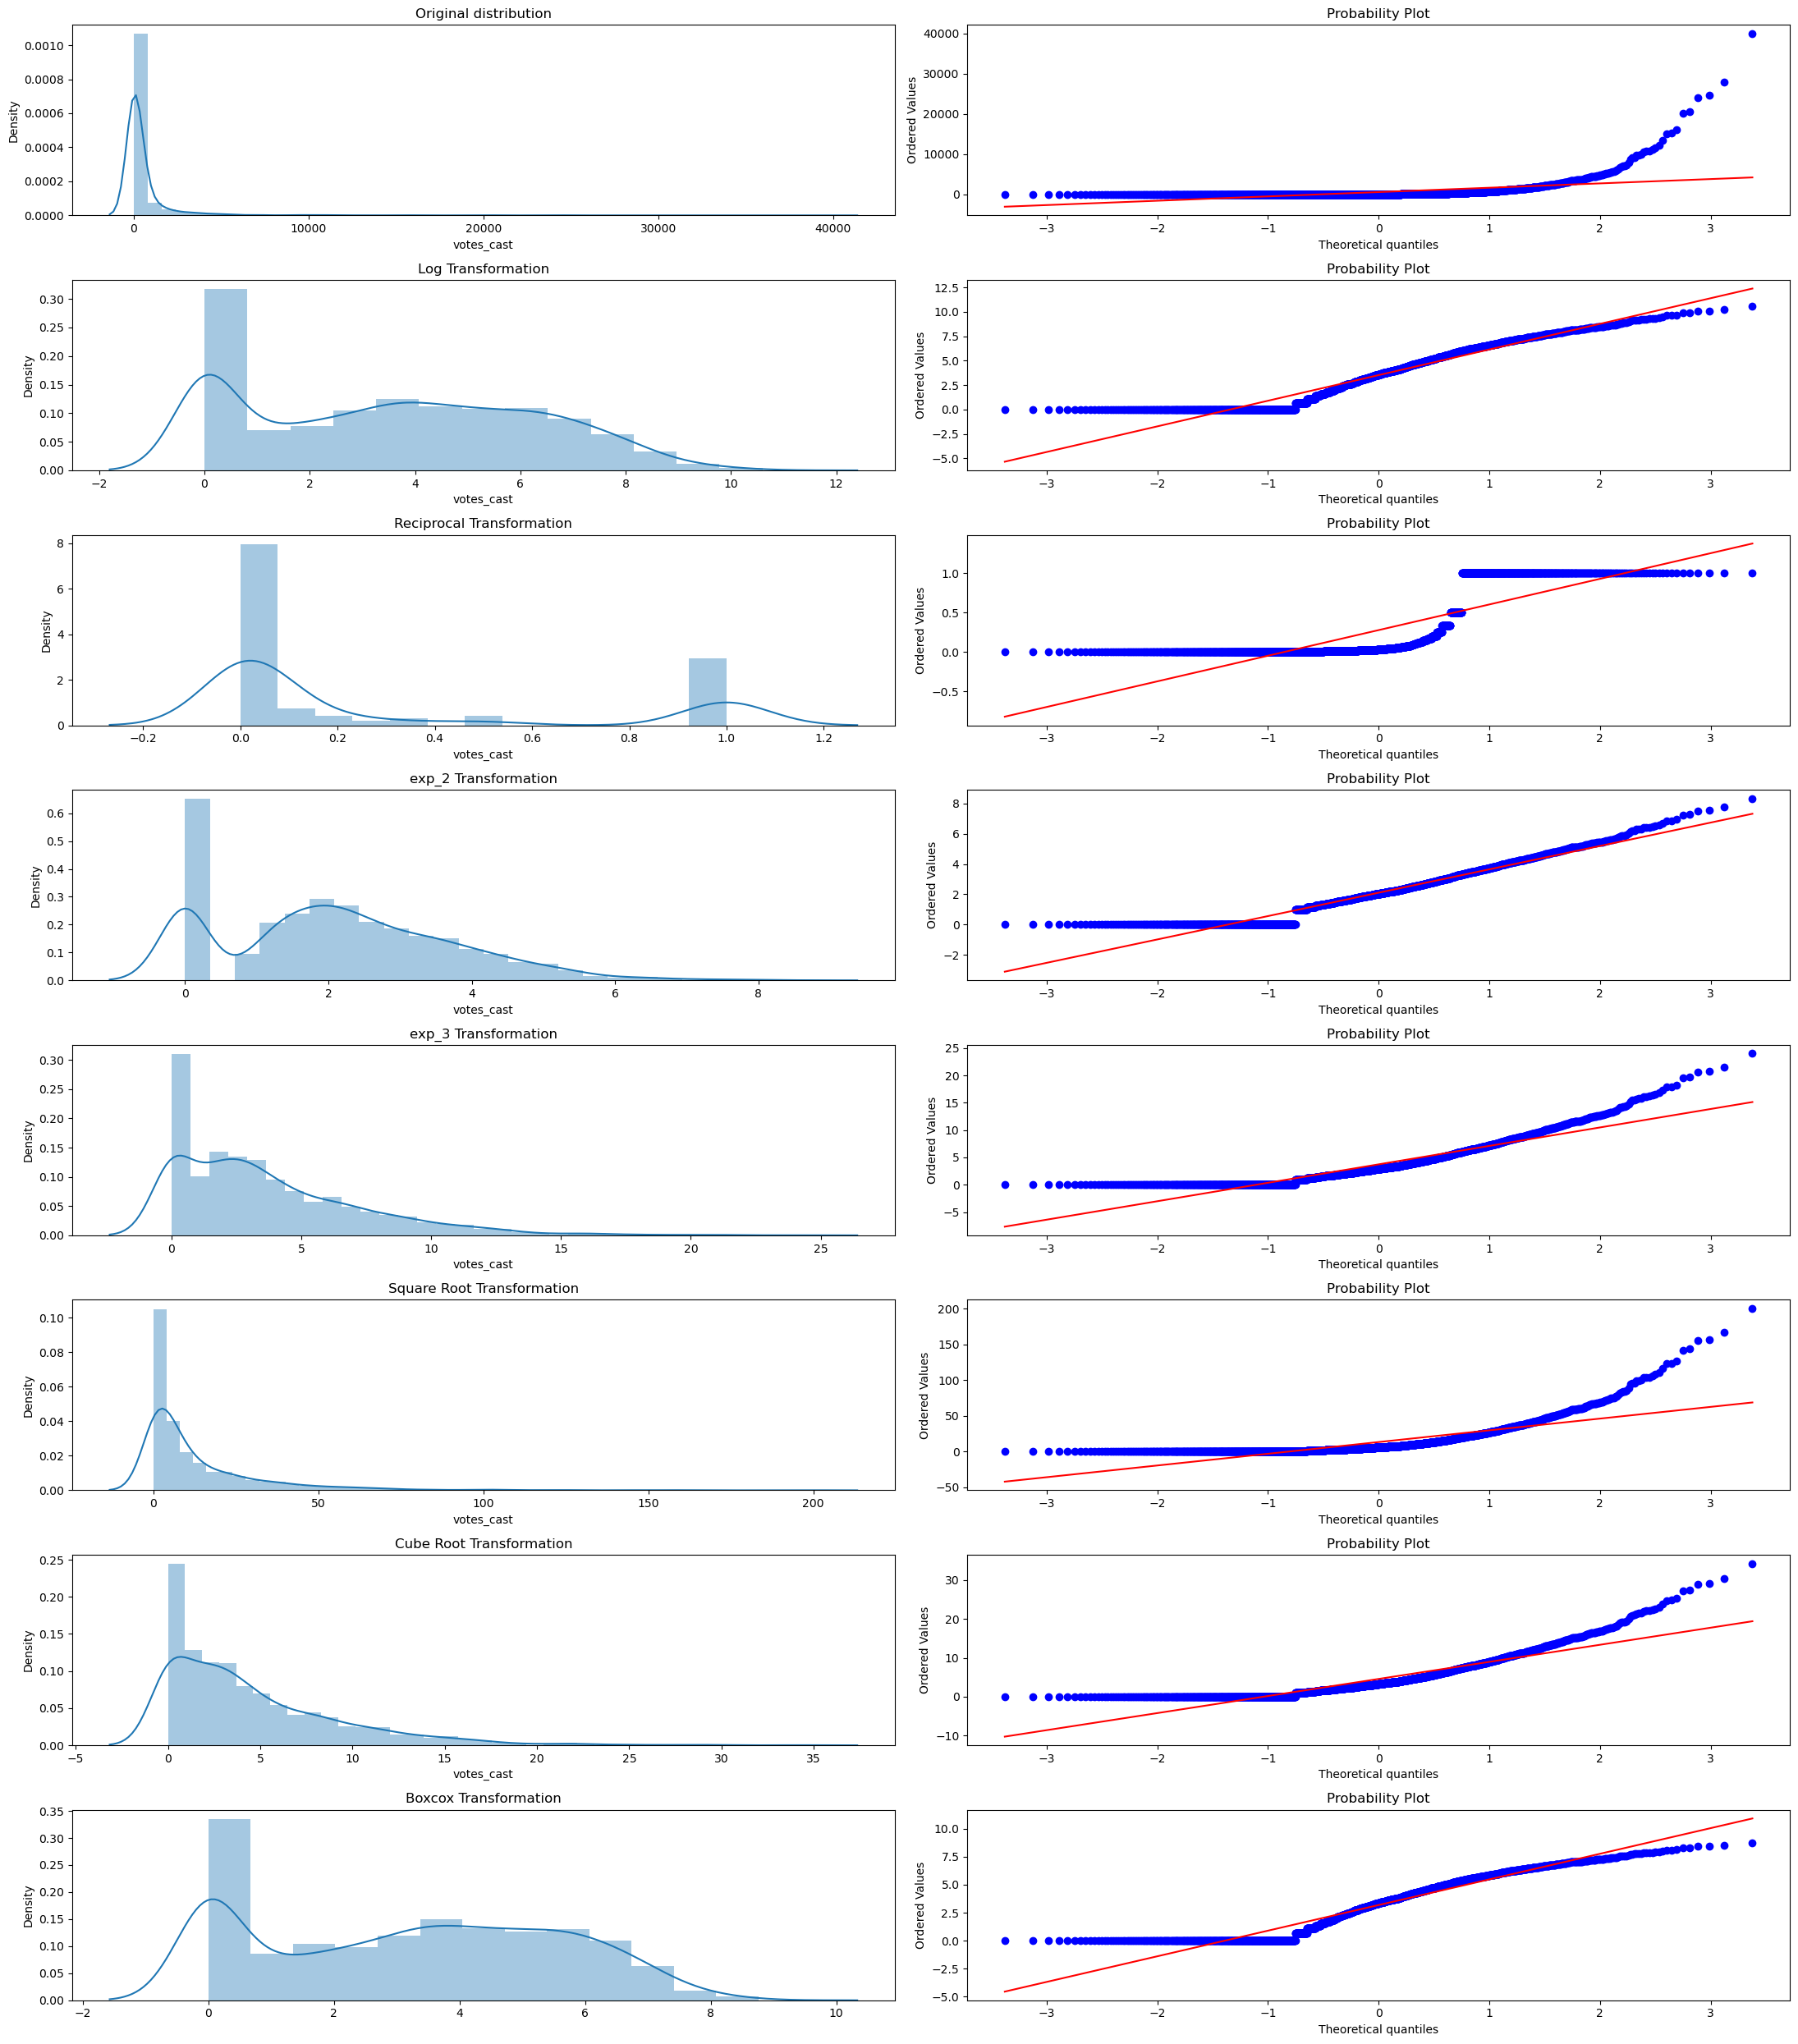

WEIGHTED_BADGE_SCORE 

       Transformation      Skew
               Actual  5.998483
                  Log -0.138597
           Reciprocal  4.033868
Exponential power 0.2 -0.107242
Exponential power 0.3  0.918484
          Square Root  2.217359
            Cube Root  1.163818
               Boxcox  0.000547

 Best Transformation for  weighted_badge_score : 
 Boxcox = 0.0005474297472142351


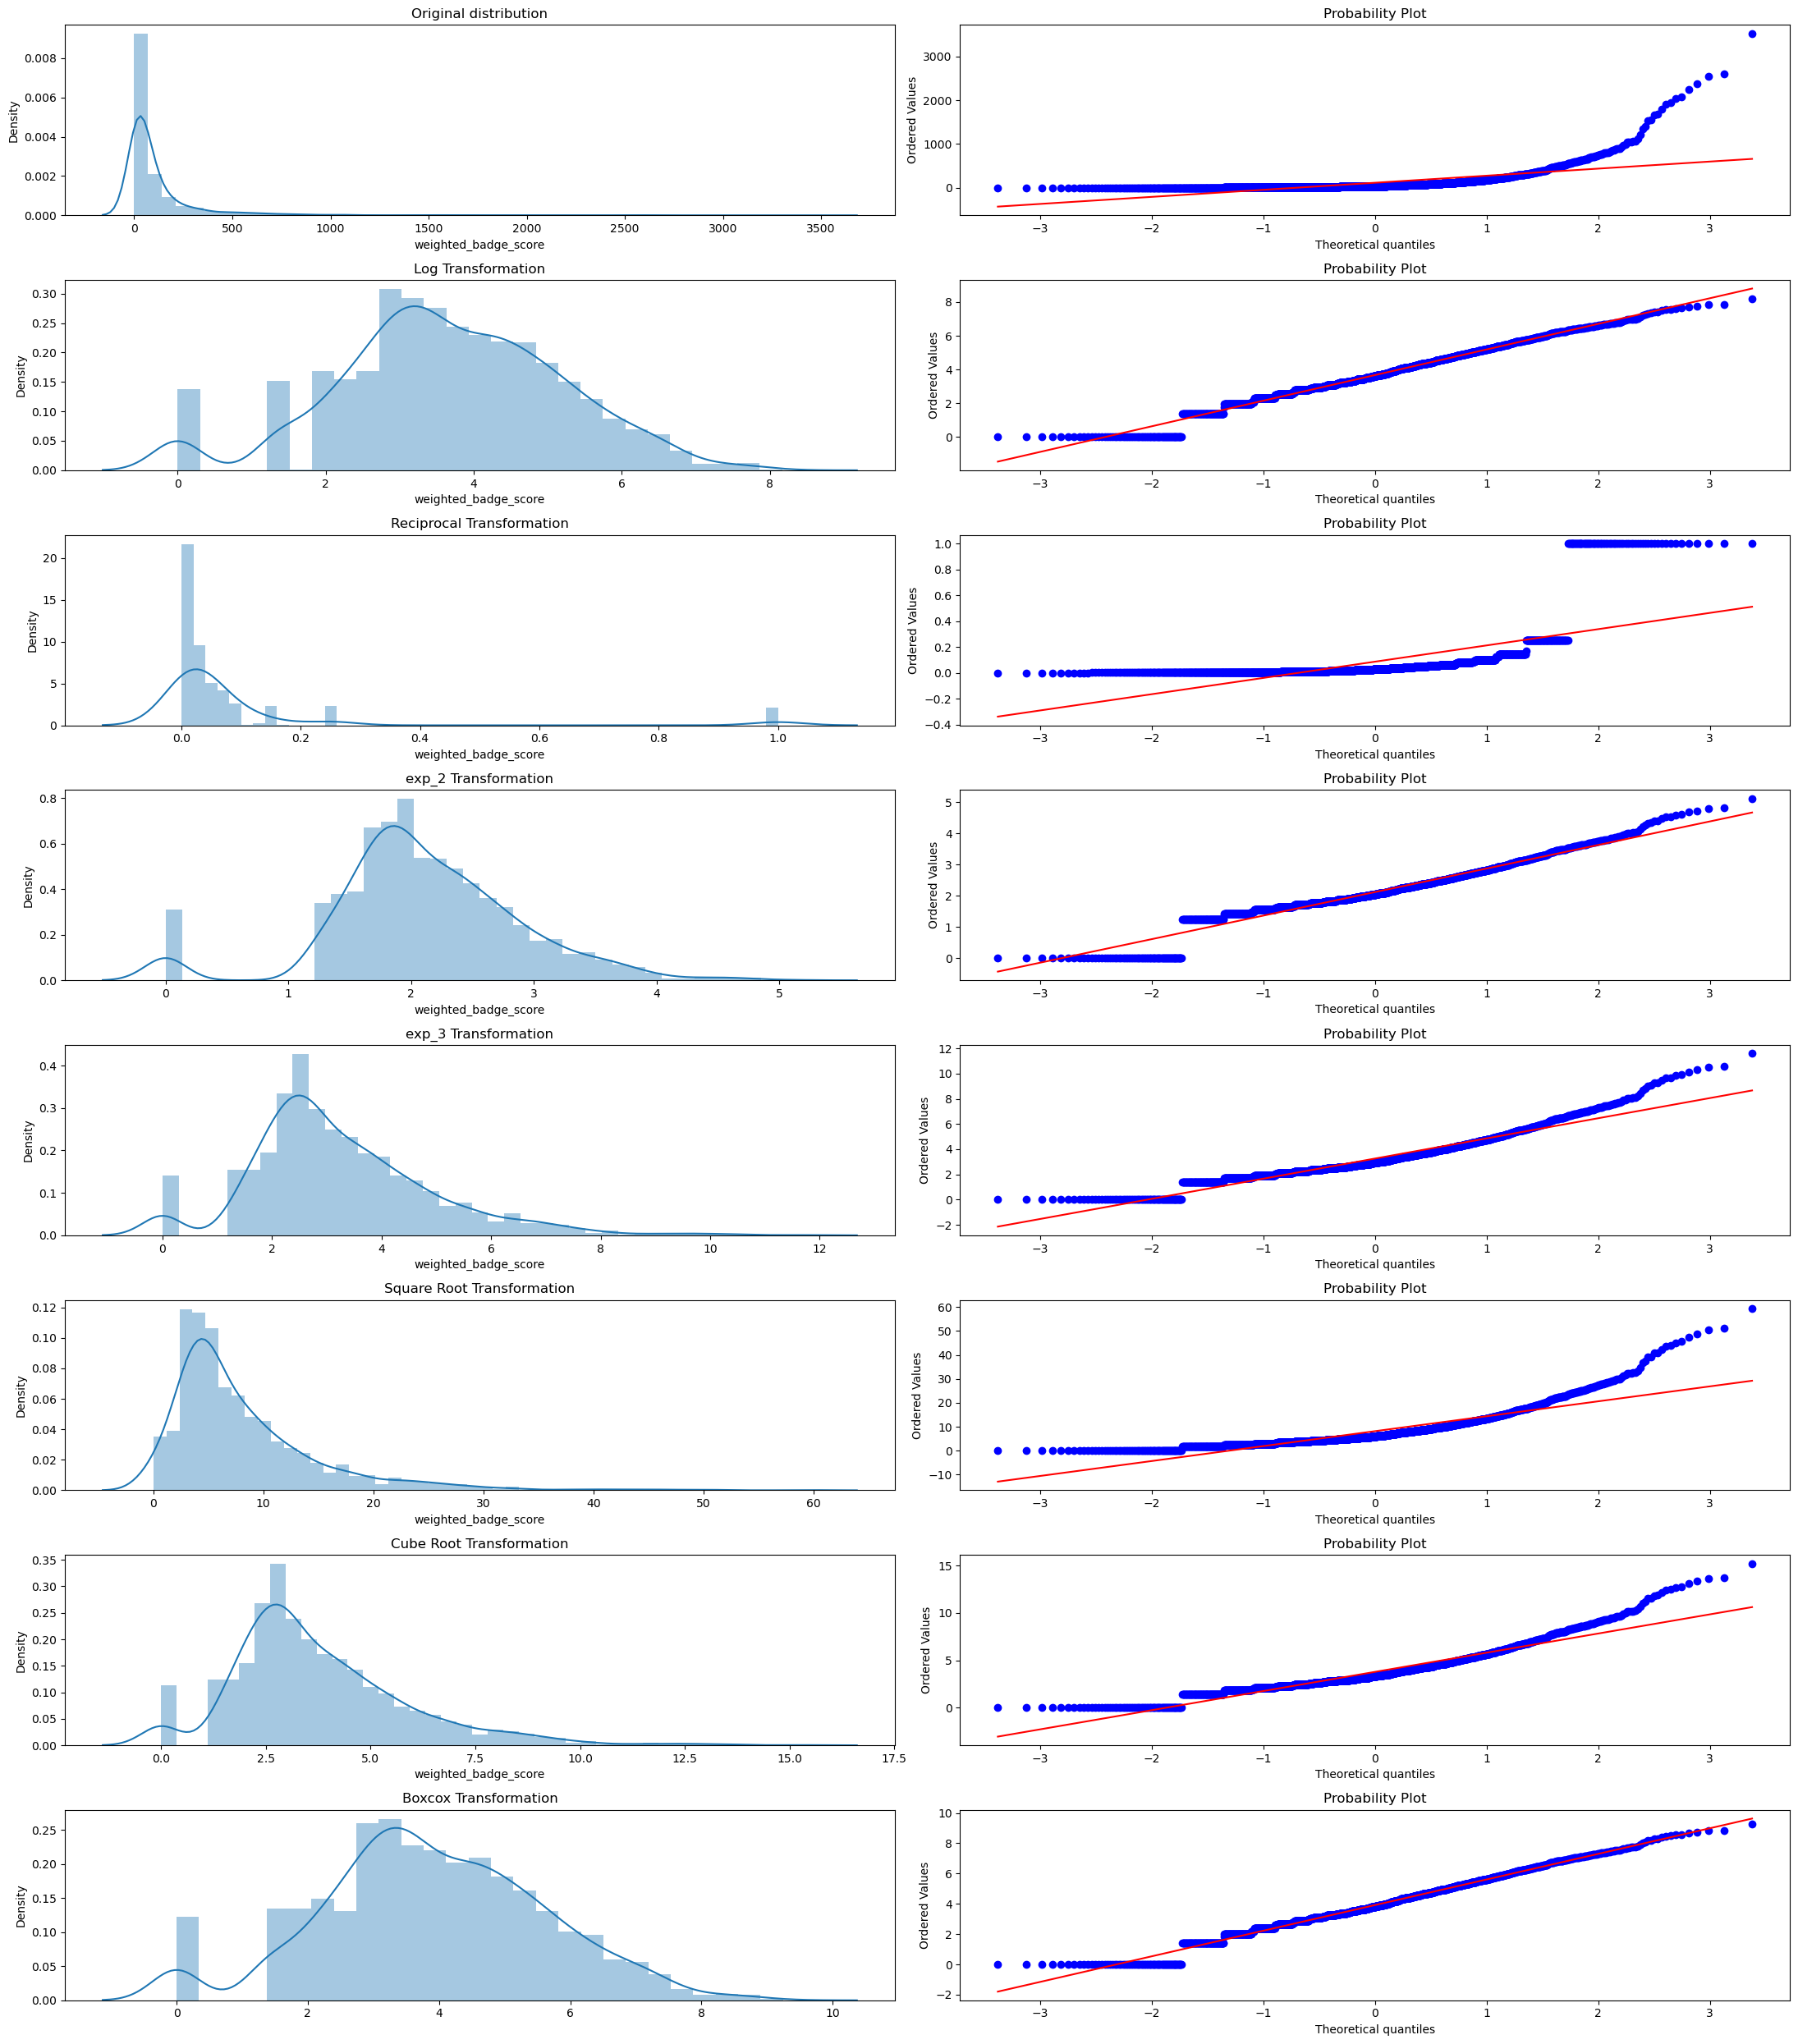

QA_RATIO 

       Transformation      Skew
               Actual 19.311502
                  Log  2.809918
           Reciprocal -0.840463
Exponential power 0.2  0.401124
Exponential power 0.3  1.965016
          Square Root  5.943846
            Cube Root  2.559653
               Boxcox  0.564700

 Best Transformation for  QA_ratio : 
 Exponential power 0.2 = 0.40112354390468025


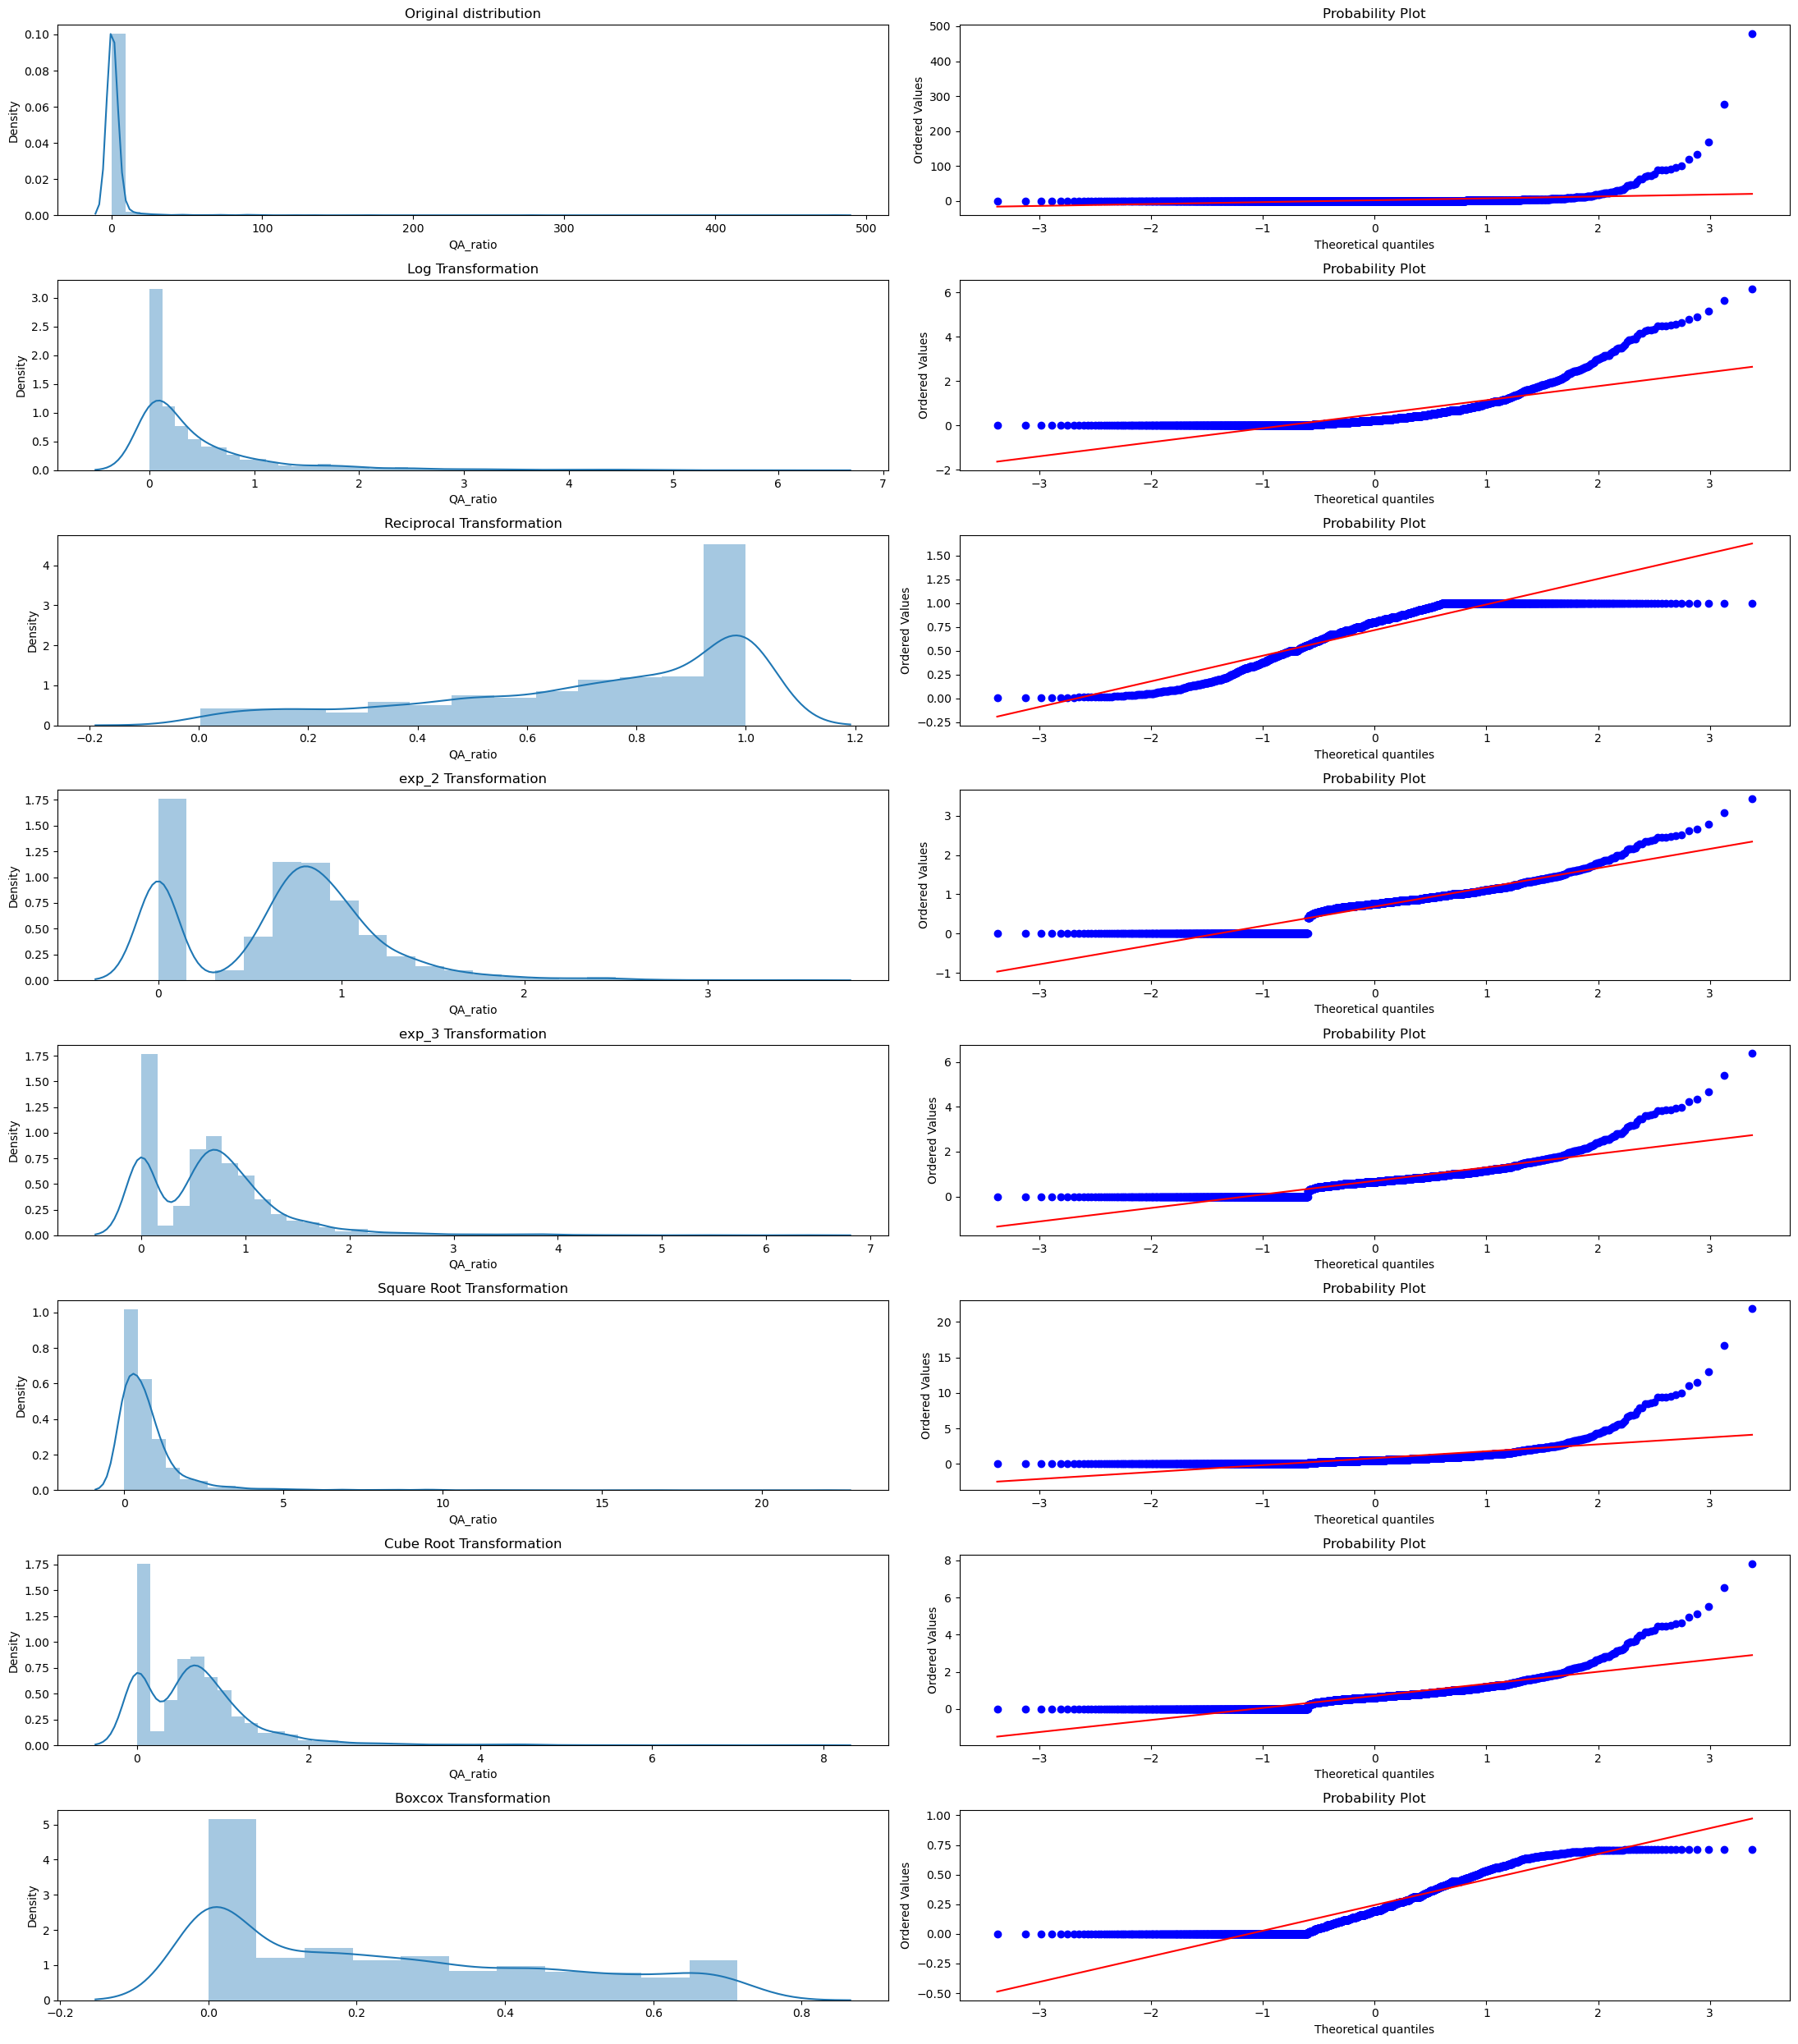

In [14]:
for column in ['reputation', 'reached', 'questions', 'answers',
        'posts_edited', 'helpful_tags', 'votes_cast',
        'weighted_badge_score', 'QA_ratio']:
    
    print('\033[1m'+column.upper()+'\033[0m','\n')
    plt.figure(figsize=(22,25))
    
    raw_skewness = df_train[column].skew()
    
    plt.subplot(8,2,1)
    sns.distplot(df_train[column])
    plt.title('Original distribution')
    
    plt.subplot(8,2,2)
    st.probplot(df_train[column],dist='norm',plot=plt)
    
    
    #log transformation
    log_transform = np.log(df_train[column]+1)
    log_skew=log_transform.skew()

    plt.subplot(8,2,3)
    sns.distplot(log_transform)
    plt.title('Log Transformation')

    plt.subplot(8,2,4)
    st.probplot(log_transform,dist='norm',plot=plt)
    
    #Reciprocal Transformation  
    recip_transform = 1/(df_train[column]+1)
    recip_skew=recip_transform.skew()

    plt.subplot(8,2,5)
    sns.distplot(recip_transform)
    plt.title('Reciprocal Transformation')

    plt.subplot(8,2,6)
    st.probplot(recip_transform,dist='norm',plot=plt)
    
    #Exponential Transformation
    
    exp_2 = df_train[column]**0.2
    exp_2_skew=exp_2.skew()
    
    plt.subplot(8,2,7)
    sns.distplot(exp_2)
    plt.title('exp_2 Transformation')
    
    plt.subplot(8,2,8)
    st.probplot(exp_2,dist='norm',plot=plt)
    
    exp_3 = df_train[column]**0.3
    exp_3_skew=exp_3.skew()
    
    plt.subplot(8,2,9)
    sns.distplot(exp_3)
    plt.title('exp_3 Transformation')
    
    plt.subplot(8,2,10)
    st.probplot(exp_3,dist='norm',plot=plt)
    
    #Square Root Transformation
    
    sqrt_transform = df_train[column]**(1/2)
    sqrt_transform_skew=sqrt_transform.skew()
    
    plt.subplot(8,2,11)
    sns.distplot(sqrt_transform)
    plt.title('Square Root Transformation')
    
    plt.subplot(8,2,12)
    st.probplot(sqrt_transform,dist='norm',plot=plt)
    
    #Cube Root Transformation
    
    cube_transform = df_train[column]**(1/3)
    cube_transform_skew=cube_transform.skew()
    
    plt.subplot(8,2,13)
    sns.distplot(cube_transform)
    plt.title('Cube Root Transformation')
    
    plt.subplot(8,2,14)
    st.probplot(cube_transform,dist='norm',plot=plt)
    
    #Boxcox Transformation
    box,param = st.boxcox(df_train[column]+1)
    boxcox_skew=pd.DataFrame(box).skew()

    plt.subplot(8,2,15)
    plt.tight_layout()
    sns.distplot(pd.DataFrame(box))
    plt.title('Boxcox Transformation')

    plt.subplot(8,2,16)
    st.probplot(box,dist='norm',plot=plt)
    
    trans_result= {'Actual':raw_skewness, 'Log':log_skew,'Reciprocal':recip_skew,'Exponential power 0.2':exp_2_skew,
                       'Exponential power 0.3':exp_3_skew,'Square Root':sqrt_transform_skew,
                       'Cube Root':cube_transform_skew,'Boxcox':boxcox_skew[0]}
    print(pd.DataFrame(trans_result.items(), columns=['Transformation', 'Skew']).to_string(index=False))
    
    lst=list(trans_result.values())
    idx = min((abs(x), x) for x in lst)[1]
    for i in trans_result:
        if (trans_result[i]==idx):
            print('\n','Best Transformation for ',column,':','\n',i,'=',trans_result[i])
    plt.tight_layout() 
    
    plt.show()

In [16]:
df_train['reputation_st'],rep = st.boxcox(df_train['reputation']+1)
df_train['reached_st'],reach = st.boxcox(df_train['reached']+1)
df_train['questions_st'],ques = st.boxcox(df_train['questions']+1)
df_train['answers_st'],ans = st.boxcox(df_train['answers']+1)
df_train['posts_edited_st'],post = st.boxcox(df_train['posts_edited']+1)
df_train['helpful_tags_st'],helpf = st.boxcox(df_train['helpful_tags']+1)
df_train['votes_cast_st'],vote = st.boxcox(df_train['votes_cast']+1)
df_train['weighted_badge_score_st'],badge = st.boxcox(df_train['weighted_badge_score']+1)
df_train['QA_ratio_st'] = df_train['QA_ratio']**0.2

## Scaling with Robust Scaler

In [17]:
st_columns = [i for i in df_train.columns if i.endswith('_st')]
scaler = RobustScaler()
df_train[st_columns] = scaler.fit_transform(df_train[st_columns])
scaled2 = scaler.fit_transform(df_train[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_train.index)
df_train = pd.concat([df_train, df_scaled2], axis=1)

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [19]:
st_columns1 = [i for i in df_train.columns if i.endswith('_st')]
calc_vif(df_train[st_columns1])

variables        VIF
0                     reputation_st  16.957225
1                        reached_st  13.396861
2                      questions_st   7.838971
3                        answers_st  14.185179
4                   posts_edited_st   3.560743
5                   helpful_tags_st   2.855525
6                     votes_cast_st   6.402532
7           weighted_badge_score_st  12.824379
8                       QA_ratio_st   7.316640
9         member_since_in_months_st   3.238872
10  total_requirements_satisfied_st        NaN

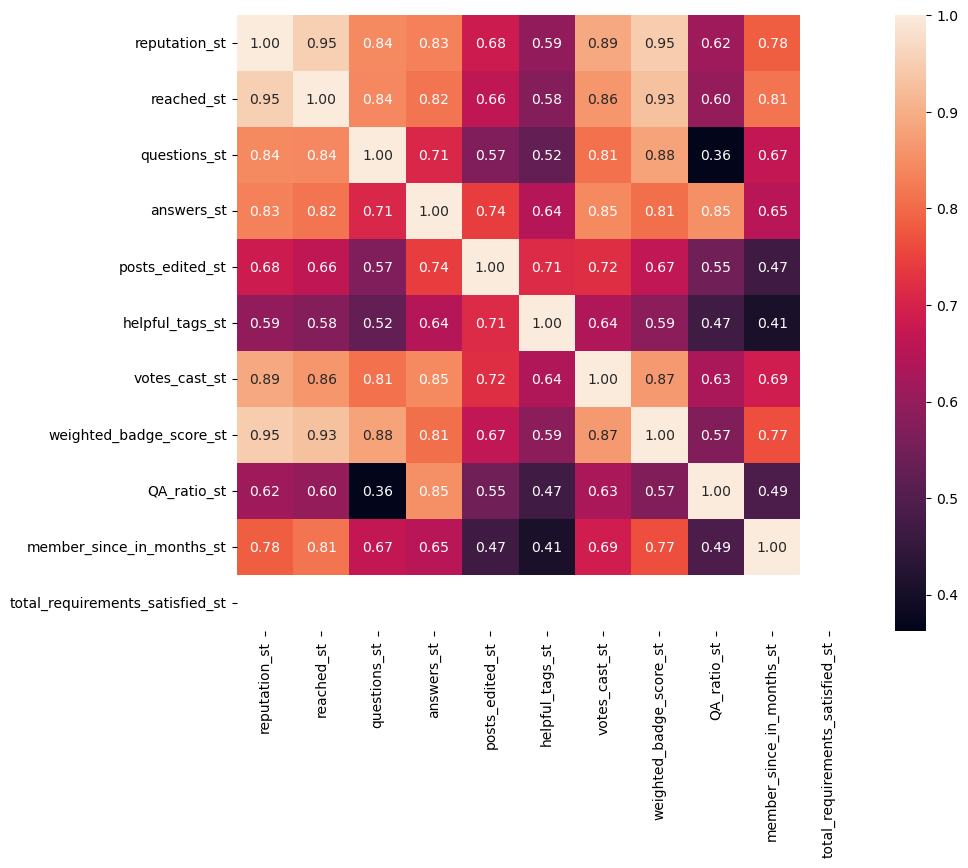

In [20]:
corr_matrix = df_train[st_columns1].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

## Modelling

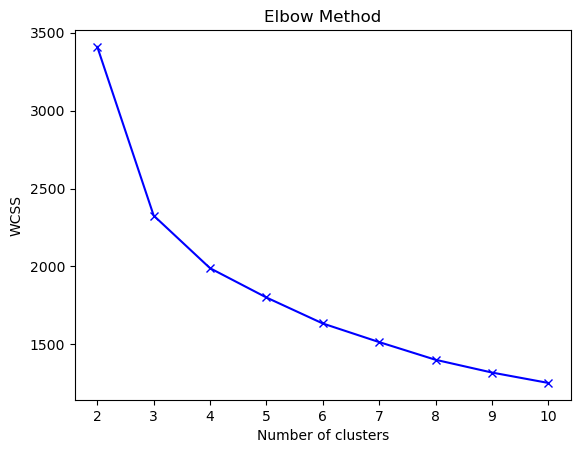

In [21]:
# kmodel.drop(columns='Cluster',inplace=True)
from sklearn.cluster import KMeans
kmodel = df_train.copy()
wcss = []
results = []
silhouette_avgs = []

for i in range(2, 11):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(kmodel[st_columns1])  # X is your data
    wcss.append(kmeans.inertia_)
    silhouette = silhouette_score(kmodel[st_columns1], kmeans.labels_)
    silhouette_avgs.append(silhouette)
    results.append({'Number of Clusters': i, 'WCSS': kmeans.inertia_})
    
elbow_data = pd.DataFrame(results)
    
plt.plot(range(2, 11), wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [22]:
elbow_data

Number of Clusters         WCSS
0                   2  3408.367571
1                   3  2326.529189
2                   4  1989.085790
3                   5  1801.210916
4                   6  1634.474995
5                   7  1515.149722
6                   8  1401.787337
7                   9  1319.920032
8                  10  1253.230127

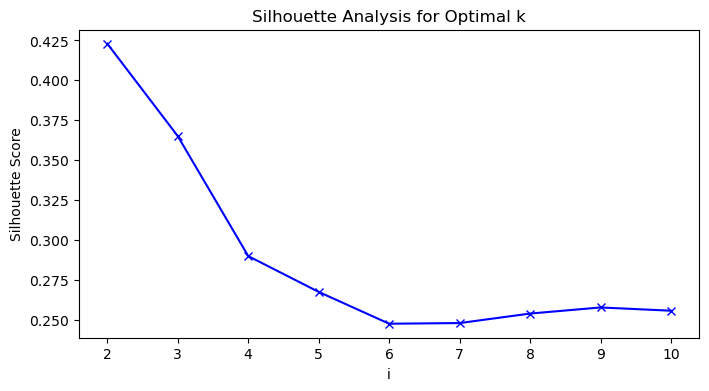

In [24]:
i = range(2, 11) 
plt.figure(figsize=(8, 4))
plt.plot(i, silhouette_avgs, 'bx-')
plt.xlabel('i')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()

In [25]:
# kmodel = pd_df[pd_df['total_requirements_satisfied']>=2]
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(kmodel[st_columns1])
kmodel['Cluster'] = kmeans.labels_
kmodel_inference = kmodel[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [26]:
kmodel_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0           2741.65   364990.12      58.27    19.14          1.17   
1            221.82    24515.24      11.26     3.34          0.24   
2          24401.77  3312899.08     144.98   330.31        193.98   
3             15.76      792.29       2.30     0.31          0.00   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.56      308.06                  133.23   
1                0.15       26.29                   81.73   
2              184.49     2123.79                  144.14   
3                0.01        0.59                   30.14   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                      100.54      1.37                           1.0  
1                       23.89      0.67                           1.0  
2                      346.01      8.24                           1.0  
3                        6.73      0.16                           1.0

In [27]:
kmodel_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        0               506
1        1               505
2        3               443
3        2               436

## Visualizing Clusters

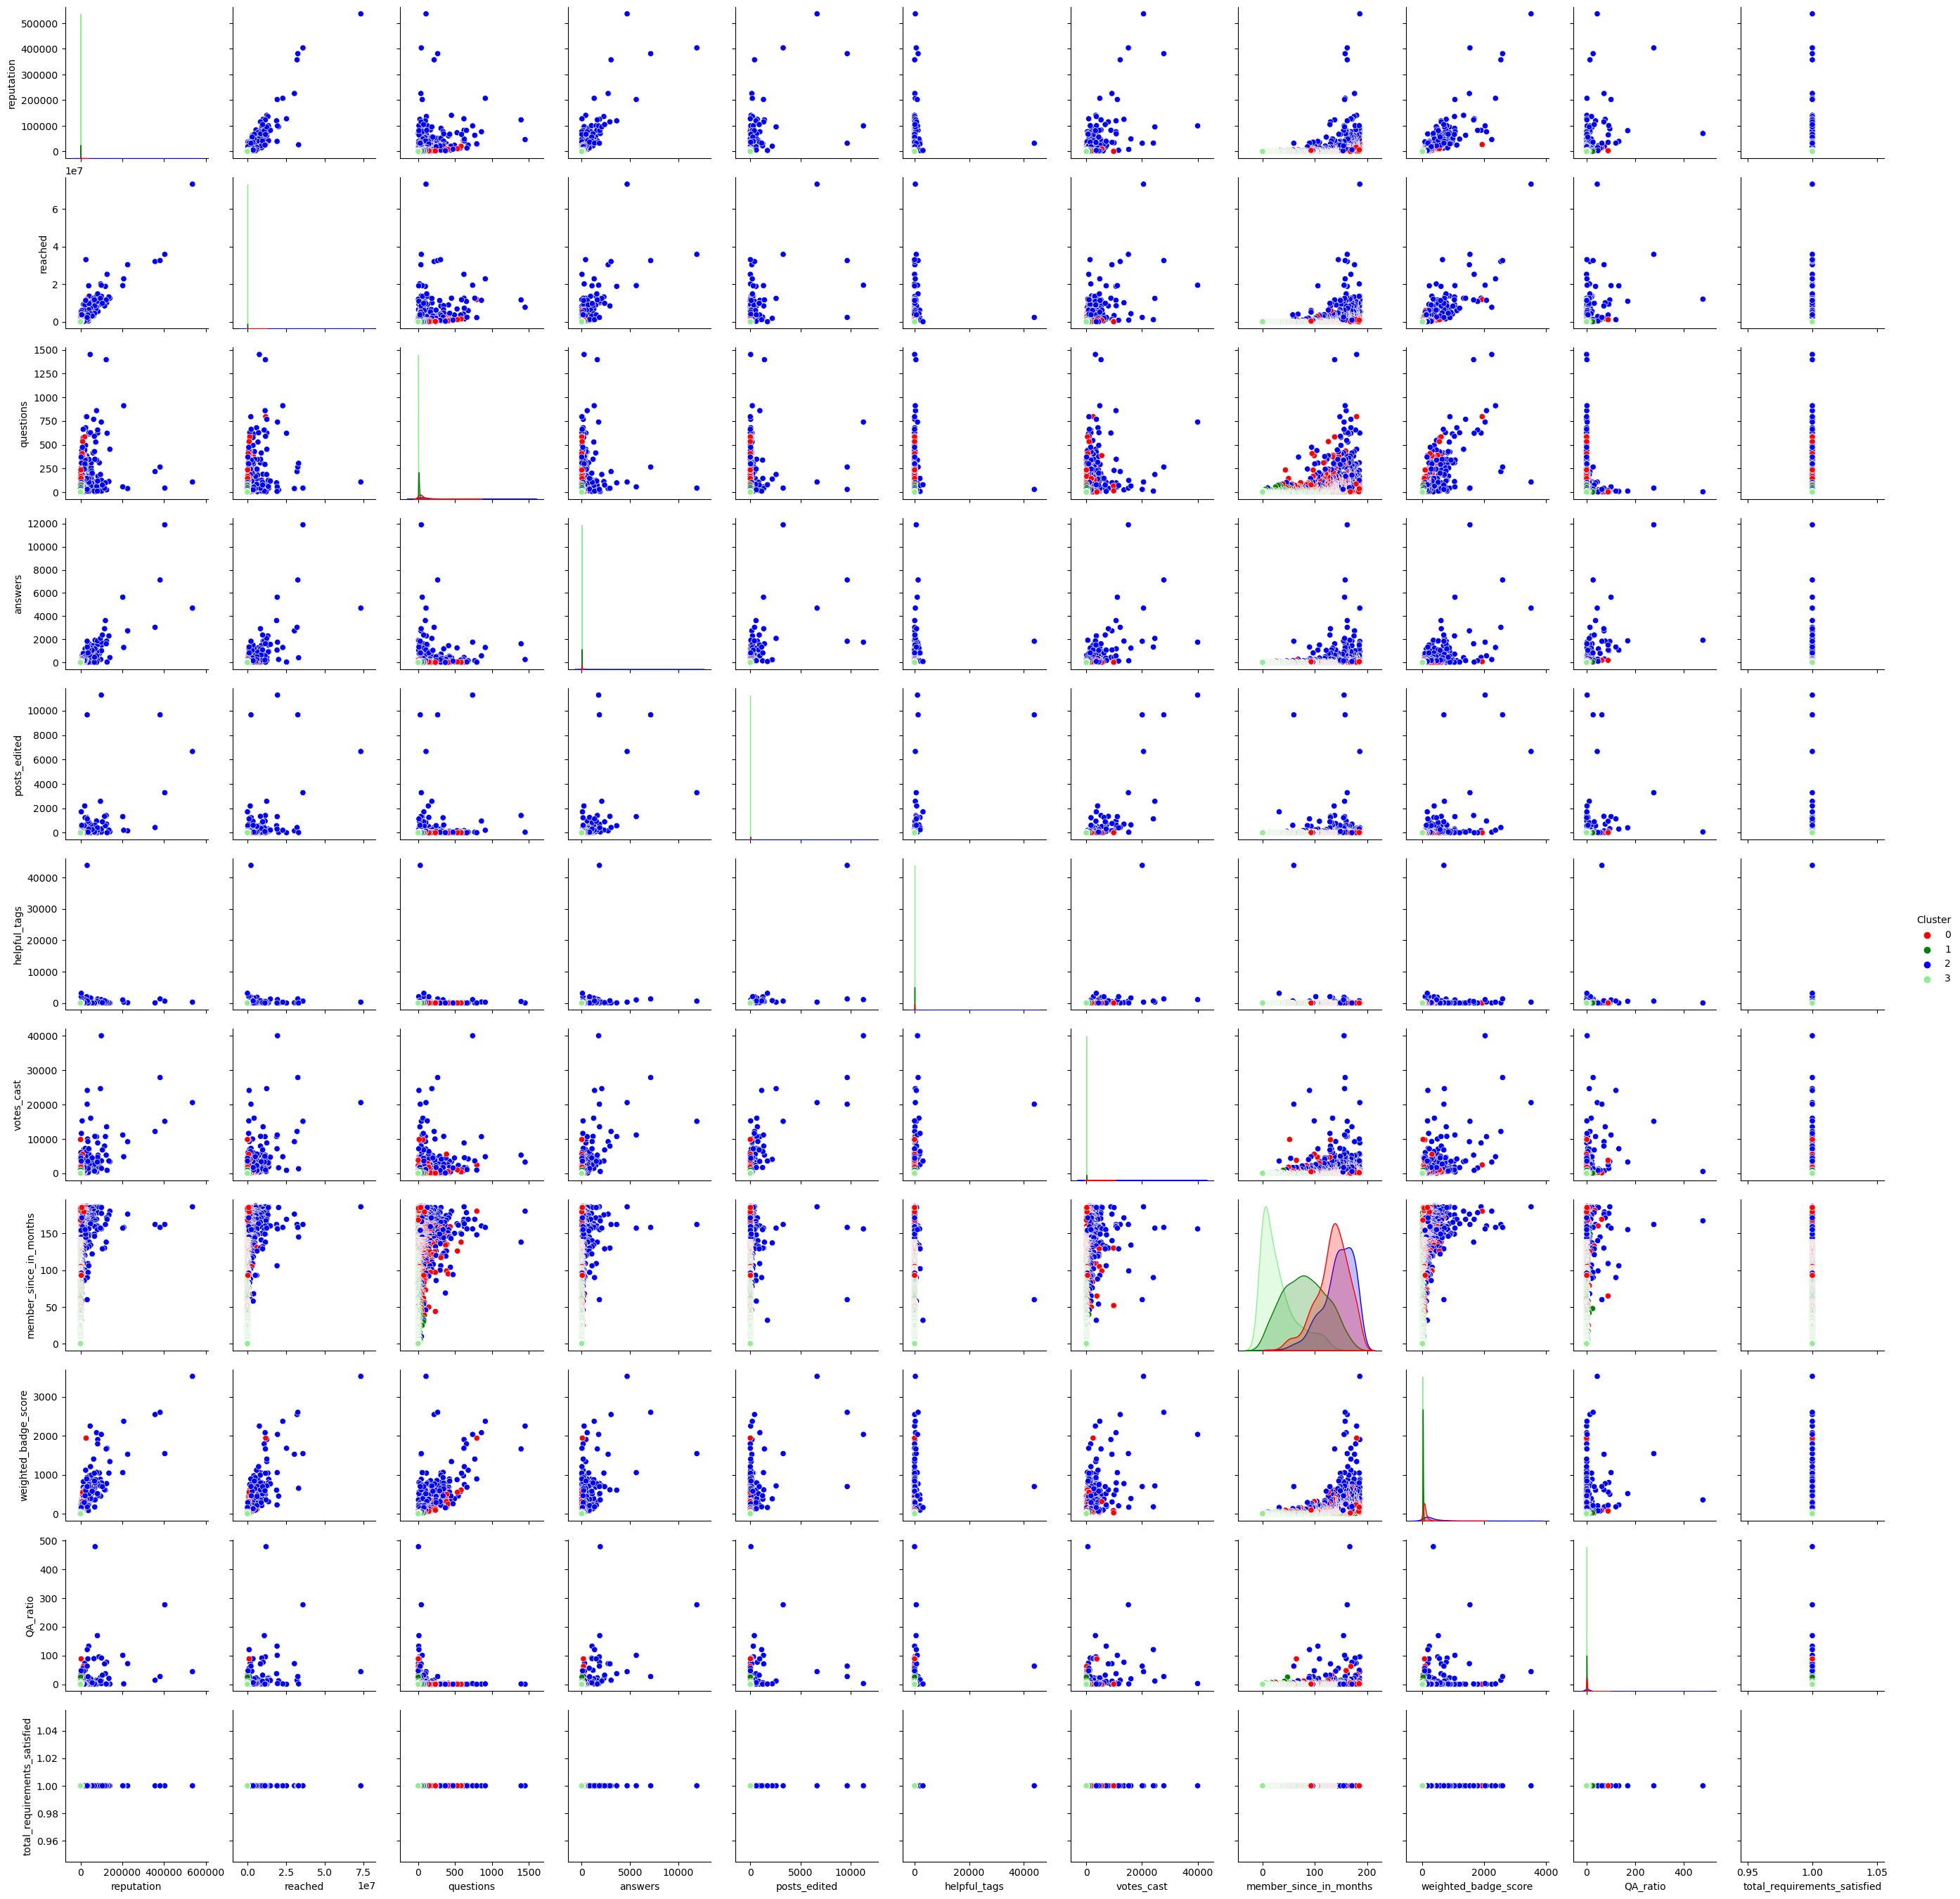

In [28]:
import seaborn as sns
palette = {0: "red", 1: "green", 2: "blue", 3: "lightgreen"} 
sns.pairplot(kmodel_inference, hue='Cluster', palette = palette)
plt.show()

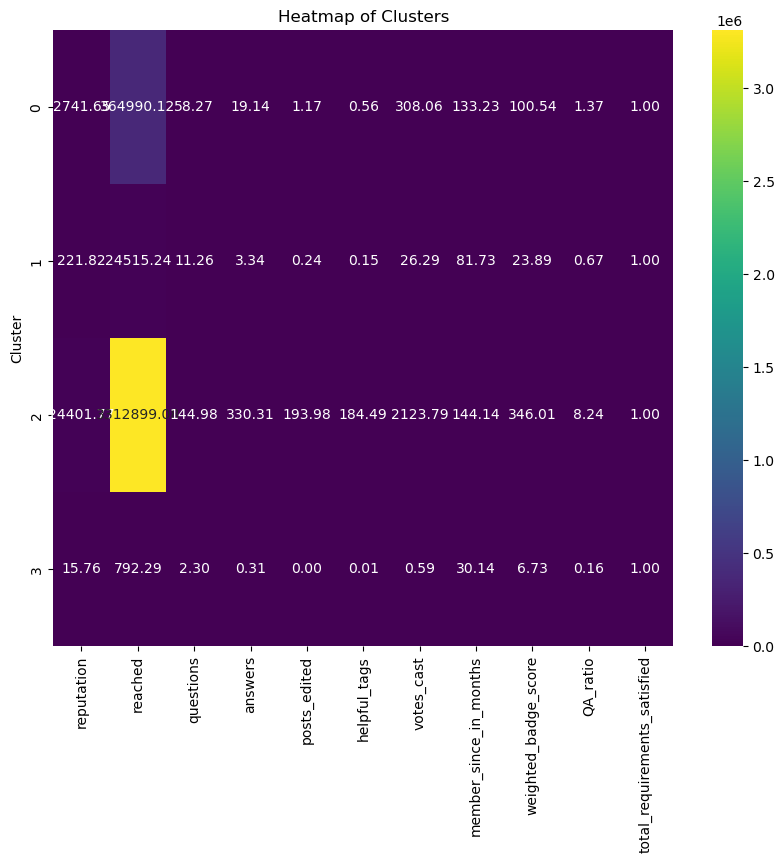

In [29]:
corr_matrix = kmodel_inference.groupby('Cluster').mean().round(2)
corr_matrix.sort_values(by='Cluster',inplace=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap = 'viridis')
plt.title('Heatmap of Clusters')
plt.show()

# Testing

In [30]:
#Cleaning the data
df_test['name'] = df_test['name'].str.replace('\n','')
df_test['name'] = df_test['name'].str.strip()

#Null Value Imputation
df_test['job_role'].fillna('NA',inplace=True)
df_test['tags'].fillna('NA',inplace=True)
df_test['gold_badges'].fillna('NA',inplace=True)
df_test['silver_badges'].fillna('0',inplace=True)
df_test['bronze_badges'].fillna('0',inplace=True)
df_test['questions'].fillna('0',inplace=True)
df_test['answers'].fillna('0',inplace=True)
df_test['reputation'].fillna('0',inplace=True)
df_test['reached'].fillna('0',inplace=True)
df_test['posts_edited'].fillna('0',inplace=True)
df_test['votes_cast'].fillna('0',inplace=True)
df_test['helpful_tags'].fillna('0',inplace=True)

df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']]=df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(lambda x:x.str.replace(",",""))

# 2. Clean k and m values
df_test['reached'] = df_test['reached'].str.strip()

def convert_k_to_num(value):
    if isinstance(value, str) and value.lower().endswith('k'):
        return float(value[:-1]) * 1000
    elif isinstance(value, str) and value.lower().endswith('m'):
        return float(value[:-1]) * 1000000
    else:
        return float(value)
    
df_test['reached'] = df_test['reached'].apply(convert_k_to_num)

# 3. Cleaning Member_Since
def convert_to_months(s):
    # Initialize years, months, and days
    years, months, days = 0, 0, 0
    
    # Find and convert years, if present
    if 'year' in s:
        years = int(s.split('year')[0].strip())
    
    # Find and convert months, if present
    if 'month' in s:
        months = int(s.split('month')[0].split(',')[-1].strip())
    
    # Find and convert days, if present
    if 'day' in s:
        days = int(s.split('day')[0].split(',')[-1].strip())
    
    # Convert everything to months (approximation)
    total_months = years * 12 + months + days / 30  # Convert days to a fraction of a month
    return total_months

# Apply the conversion function to your 'Member_Since' column
df_test['member_since_in_months'] = df_test['member_since'].apply(convert_to_months)
df_test['member_since_in_months'] = df_test['member_since_in_months'].round(2)

#Type Casting
df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']] = df_test[['silver_badges', 'bronze_badges','posts_edited', 'helpful_tags', 'votes_cast', 'reputation','reached', 'answers', 'questions']].apply(pd.to_numeric)

#Feature Engineering
df_test['weighted_badge_score'] = (3 * df_test['gold_badges']) + (2 * df_test['silver_badges']) + df_test['bronze_badges']
df_test['questions'] = np.where(df_test['questions']==0, 1, df_test['questions'])
df_test['QA_ratio'] = (df_test['answers']/df_test['questions']).round(2)

#dropping this because there's a weighted badge score
df_test.drop(columns=['gold_badges', 'silver_badges', 'bronze_badges'], inplace=True)

#Creating flags
df_test['tags'] = df_test['tags'].apply(lambda x:x.split(','))
df_test['Programming_Language_Flag'] = np.where(df_test['tags'].apply(lambda x:'c++' in x),1,0)
df_test['total_requirements_satisfied'] = df_test['Programming_Language_Flag']

#Shortlisting Candidates with Valid Skill
df_test = df_test[df_test['total_requirements_satisfied']==1]

#Transformations
df_test['reputation_st'],rep = st.boxcox(df_test['reputation']+1)
df_test['reached_st'],reach = st.boxcox(df_test['reached']+1)
df_test['questions_st'],ques = st.boxcox(df_test['questions']+1)
df_test['answers_st'],ans = st.boxcox(df_test['answers']+1)
df_test['posts_edited_st'],post = st.boxcox(df_test['posts_edited']+1)
df_test['helpful_tags_st'],helpf = st.boxcox(df_test['helpful_tags']+1)
df_test['votes_cast_st'],vote = st.boxcox(df_test['votes_cast']+1)
df_test['weighted_badge_score_st'],badge = st.boxcox(df_test['weighted_badge_score']+1)
df_test['QA_ratio_st'] = df_test['QA_ratio']**0.2

#Scaling with Robust Scaler
st_columns = [i for i in df_test.columns if i.endswith('_st')]
scaler = RobustScaler()
df_test[st_columns] = scaler.fit_transform(df_test[st_columns])
scaled2 = scaler.fit_transform(df_test[['member_since_in_months','total_requirements_satisfied']])
df_scaled2 = pd.DataFrame(scaled2, columns=['member_since_in_months_st','total_requirements_satisfied_st'], index=df_test.index)
df_test = pd.concat([df_test, df_scaled2], axis=1)
st_columns1 = [i for i in df_test.columns if i.endswith('_st')]

df_test['Cluster'] = kmeans.predict(df_test[st_columns1])
testing_inference = df_test[['reputation', 'reached',
       'questions', 'answers',
       'posts_edited', 'helpful_tags', 'votes_cast', 'member_since_in_months',
       'weighted_badge_score', 'QA_ratio','total_requirements_satisfied','Cluster']]

In [31]:
testing_inference.groupby('Cluster').mean().round(2)

reputation     reached  questions  answers  posts_edited  \
Cluster                                                             
0           3774.69   536097.40      75.66    25.43          0.95   
1            190.24    16275.20      10.45     2.67          0.15   
2          24461.07  3737402.99     165.78   376.88        207.35   
3             16.74      708.34       2.46     0.26          0.00   

         helpful_tags  votes_cast  member_since_in_months  \
Cluster                                                     
0                0.81      228.60                  131.69   
1                0.09       28.27                   83.37   
2               74.81     2279.70                  141.51   
3                0.01        0.97                   28.90   

         weighted_badge_score  QA_ratio  total_requirements_satisfied  
Cluster                                                                
0                      118.83      0.85                           1.0  
1                       23.61      0.54                           1.0  
2                      371.09      7.90                           1.0  
3                        7.15      0.14                           1.0

In [32]:
testing_inference.Cluster.value_counts().reset_index(name='No of Candidates')

Cluster  No of Candidates
0        1               157
1        0               154
2        3               140
3        2               134

# Validation

In [33]:
from sklearn.metrics import silhouette_score

# Combine the training and testing data for a comprehensive silhouette analysis
combined = np.vstack((kmodel[st_columns1], df_test[st_columns1]))
clusters_combined = np.concatenate((kmodel['Cluster'], df_test['Cluster']))

# Compute the silhouette score
silhouette_avg = silhouette_score(combined, clusters_combined)
print('Combined Silhouette Score:', silhouette_avg)

Combined Silhouette Score: 0.2794527337398794


In [34]:
dir_path = './model_pickle_files'

# Define the complete file path including the name of the pickle file
file_path = os.path.join(dir_path, 'cpluplus-developer-model.pkl')

# Ensure the directory exists, create if it doesn't
os.makedirs(dir_path, exist_ok=True)

# Save the model as a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(kmeans, file)

print(f"Model saved successfully at {file_path}")

Model saved successfully at ./model_pickle_files/cpluplus-developer-model.pkl
